# ENSO Recharge Oscillator Practical: Simulations and Forecasting
This notebook is the Recharge Oscillator (RO) Practical for the [ENSO Winter School 2025](https://sites.google.com/hawaii.edu/enso-winter-school-2025/). The practical covers theoretical and computational aspects of the RO framework, its applications in ENSO simulations, and forecasting.

**Instructors**:
- Sen Zhao <zhaos@hawaii.edu>
- Soong-Ki Kim <sskk503@yonsei.ac.kr>        

**Reviewer**
- Jérôme Vialard

In this notebook, we will demonstrate how to `XRO` framework for **Recharge-Oscilattor (RO)** model fitting, simulations and reforecasting.

We will also briefly introduce a `Comunitity Recharge Oscillator (CRO)` framework which can be used in this applcaitions. Due to the unavailablity of some functionalities of `CRO`, we will use `XRO` framework for consistentiy. For people interested in the `CRO` code, please refer to the jupyter notebook `RO_parctical_with_CRO_framework.ipynb`.



## 0. Preliminary 

Load basic python libraries
Include libraries for both computing and visualization

In [1]:
import importlib.util
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

# Function to check and install a package if not found
def install_if_missing(package):
    if importlib.util.find_spec(package) is None:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    else:
        print(f"{package} is already installed.")

# List of required packages
required_packages = [
    "matplotlib", "numpy", "xarray", "climpred", "dateutil", "nc-time-axis", "seaborn",
]

# # Install missing packages if needed
# for pkg in required_packages:
#     install_if_missing(pkg)

# Importing libraries after ensuring they are installed
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from climpred import HindcastEnsemble
from dateutil.relativedelta import *
from matplotlib.ticker import AutoMinorLocator


In [2]:
## if you run in google colab, you need to uncomment the following and download the data and XRO source code to run this notebook

# !wget -c https://github.com/senclimate/XRO/raw/main/data/XRO_indices_oras5.nc
# !wget -c https://github.com/senclimate/XRO/raw/main/code/XRO.py

from XRO import XRO, xcorr
from XRO_utils import SkewAccessor, plot_above_below_shading, plot_fill_between, pmtm


## 1. Observed ENSO properties related to RO

Two indices are used to describe the oscillatory behaviour of ENSO. 
 - **$T$**: Sea surface temperature (SST) anomalies averaged over the Niño3.4 region 170°–120° W, 5° S–5° N
 - **$h$** Thermocline depth anomalies averaged over the equatorial Pacific 120° E–80° W, 5° S–5° N, that is, the WWV index (with a constant factor of the area it covers).


### 1.1 ENSO time series

<xarray.Dataset>
Dimensions:  (time: 552)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2024-12-01
    month    (time) int32 ...
Data variables:
    Nino34   (time) float32 ...
    WWV      (time) float32 ...


Text(0.5, 1.0, 'ORAS5 Nino3.4 and WWV indices')

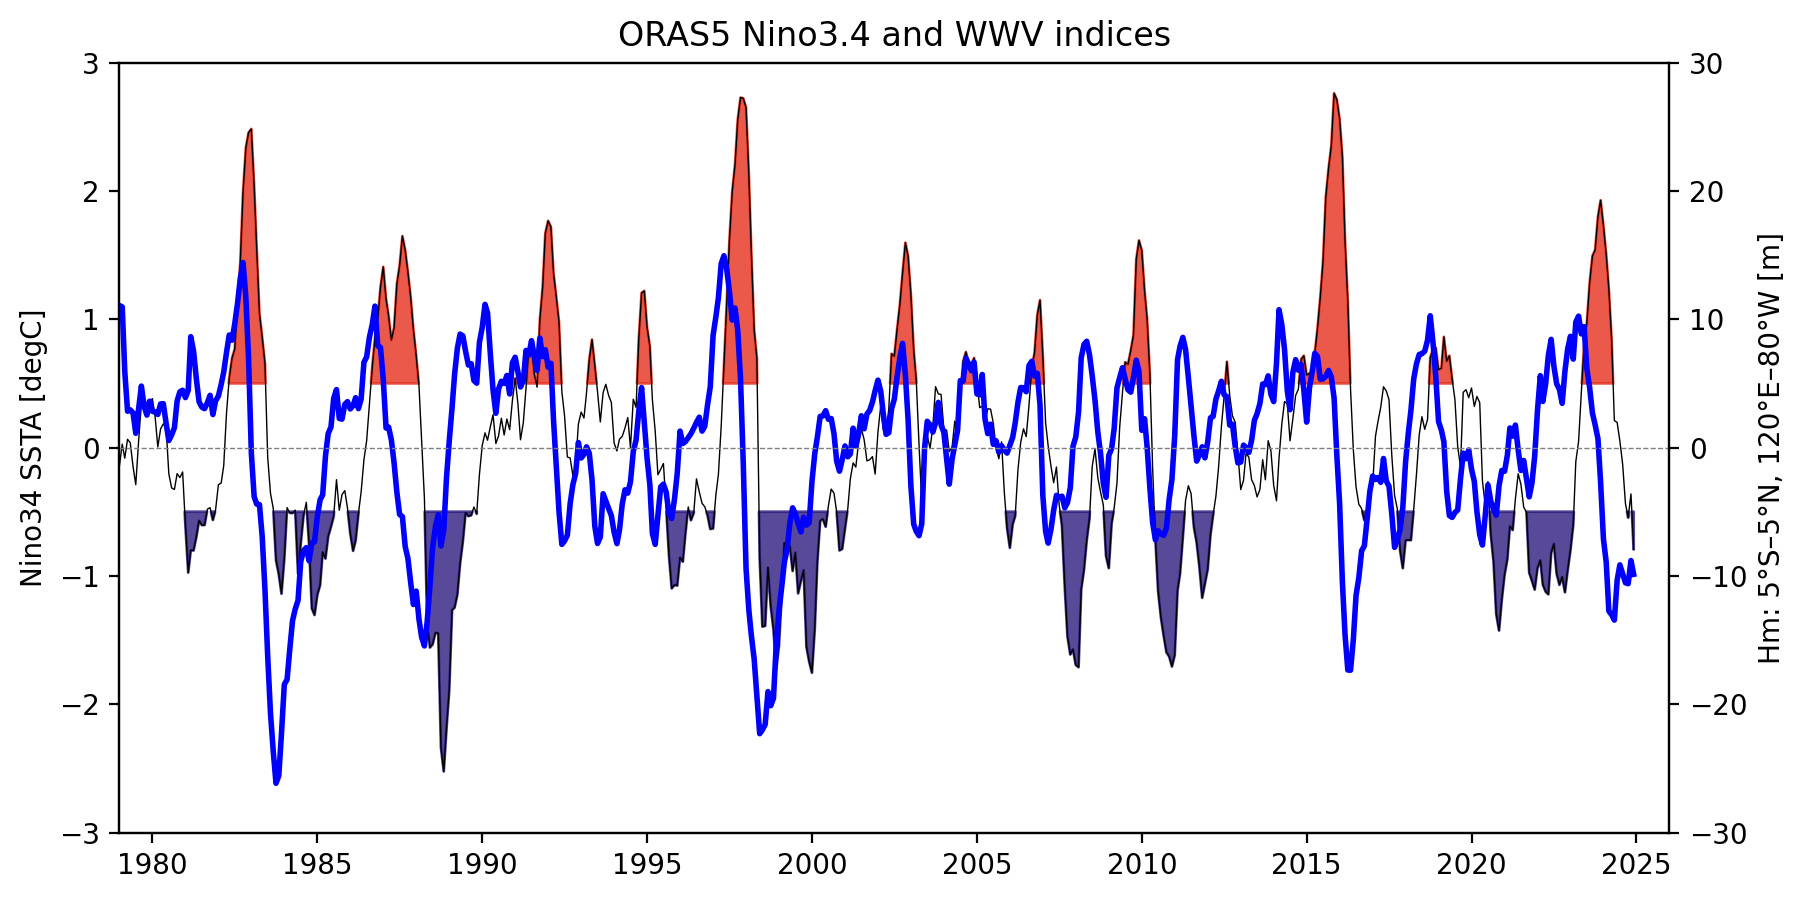

In [3]:
# load observed state vectors of XRO: which include ENSO, WWV, and other modes SST indices
# the order of variables is important, with first two must be ENSO SST and WWV;
obs_ds = xr.open_dataset('../data/XRO_indices_oras5.nc').sel(time=slice('1979-01', '2024-12'))
obs_RO_ds = obs_ds[['Nino34', 'WWV']]
print(obs_RO_ds)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plot_above_below_shading(obs_RO_ds['Nino34'], xtime=obs_RO_ds.time, c='black', lw=0.5, ax=ax)
# obs_RO_ds['Nino34'].plot(ax=ax, c='black', )
ax.set_ylim([-3, 3])
ax.set_ylabel('Nino34 SSTA [degC]')

axR = ax.twinx()
obs_RO_ds['WWV'].plot(ax=axR, c='blue', lw=2)
axR.set_ylim([-30, 30])
axR.axhline(0, ls='--', c='gray', lw=0.5)

ax.set_xlim([datetime.datetime(1979, 1, 1), datetime.datetime(2026, 1, 1)])
ax.set_title('ORAS5 Nino3.4 and WWV indices')

### 1.2 Observed ENSO seasonal synchronization
It can be represented as ENSO SSTA's seasonal variance (or standard deviation)

In [4]:
stddevAC_obs_ds = obs_RO_ds.groupby('time.month').std('time')
print(stddevAC_obs_ds)

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Nino34   (month) float64 1.142 0.9521 0.7425 0.5979 ... 1.039 1.195 1.224
    WWV      (month) float64 5.734 6.448 7.07 7.344 ... 7.267 7.673 7.049 6.229


Text(0.5, 1.0, 'ENSO seasonal synchronization')

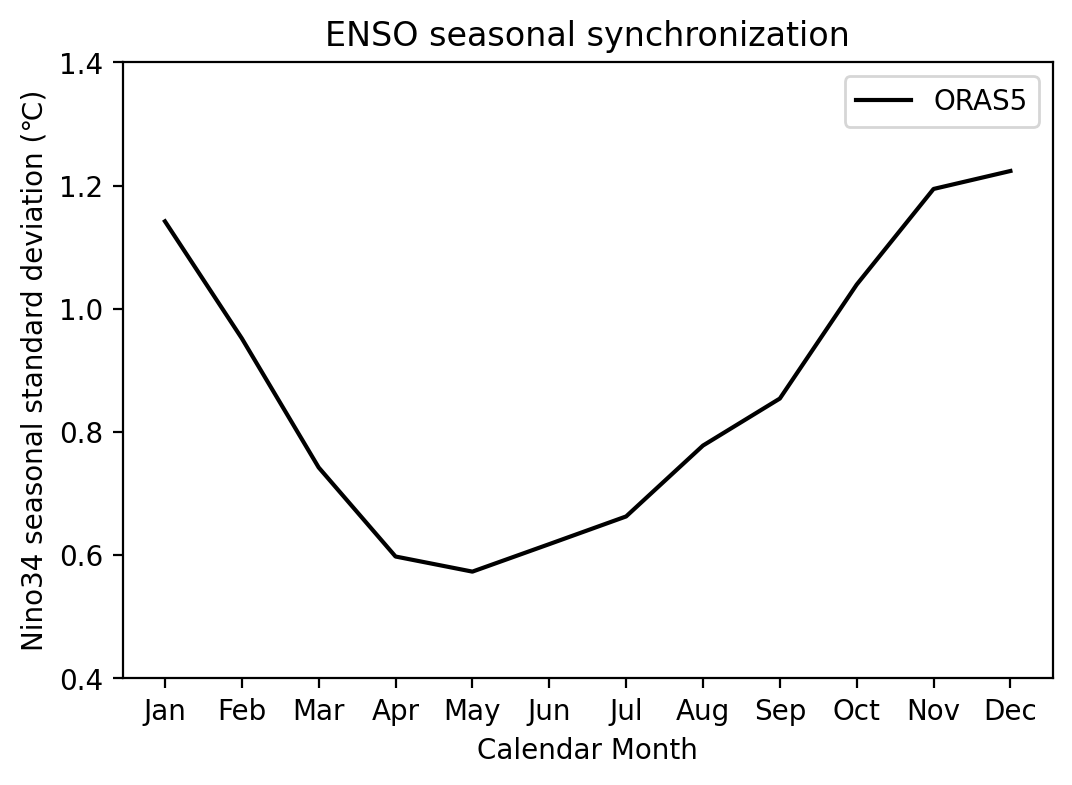

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

plt.xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Nino34 seasonal standard deviation (℃)')
plt.xlabel('Calendar Month')
plt.legend()
plt.ylim([0.4, 1.4])
plt.title('ENSO seasonal synchronization')

### 1.3 Observed ENSO asymmetry and skewness

- check the function compute_skew in XRO_utils.py
- ENSO's skewness

In [6]:
skew_obs_ds = obs_RO_ds.skew('time')
print(skew_obs_ds)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    Nino34   float64 0.4996
    WWV      float64 -0.9064


### 1.4 ENSO SST-WWV relationships

In [7]:
ccr_obs_ds = xcorr(obs_RO_ds, obs_RO_ds['Nino34'], maxlags=36)
print(ccr_obs_ds)

<xarray.Dataset>
Dimensions:  (lag: 73)
Coordinates:
  * lag      (lag) int32 -36 -35 -34 -33 -32 -31 -30 ... 30 31 32 33 34 35 36
Data variables:
    Nino34   (lag) float64 0.0004787 0.001371 -0.008197 ... 0.001371 0.0004787
    WWV      (lag) float64 -0.1614 -0.1661 -0.1732 ... 0.2104 0.1919 0.1674


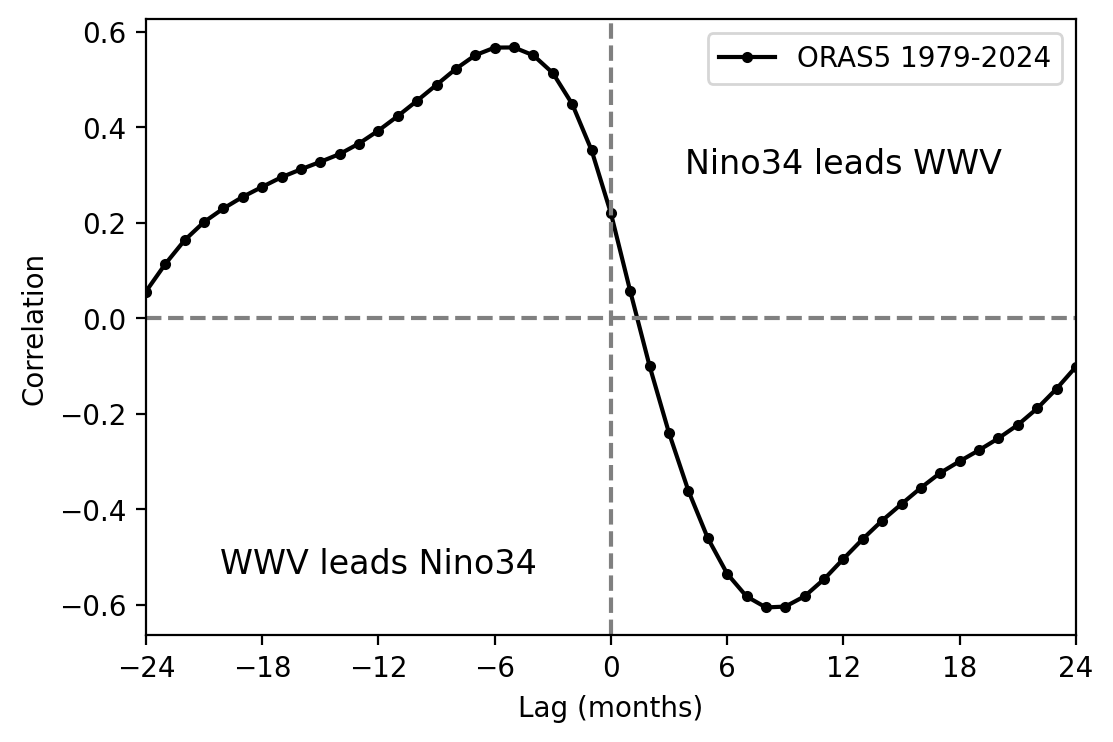

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sel_var = 'WWV'
ax.plot(ccr_obs_ds.lag, ccr_obs_ds[sel_var], c='black', marker='.', label='ORAS5 1979-2024')

ax.set_ylabel('Correlation')
ax.set_xlabel('Lag (months)')
ax.set_xticks(np.arange(-36, 37, step=6))
ax.text(0.25, 0.1,'WWV leads Nino34', ha='center', transform=ax.transAxes, fontsize='large')
ax.text(0.75, 0.75,'Nino34 leads WWV', ha='center', transform=ax.transAxes, fontsize='large')
ax.set_xlim([-24, 24])
ax.axhline(0, ls='--', c='gray')
ax.axvline(0, ls='--', c='gray')
ax.legend()

#### decadal shift in ENSO SST-WWV relationship
- McPhaden, M. J. (2012). A 21st century shift in the relationship between ENSO SST and warm water volume anomalies. Geophysical Research Letters, 39(9). https://doi.org/10.1029/2012GL051826

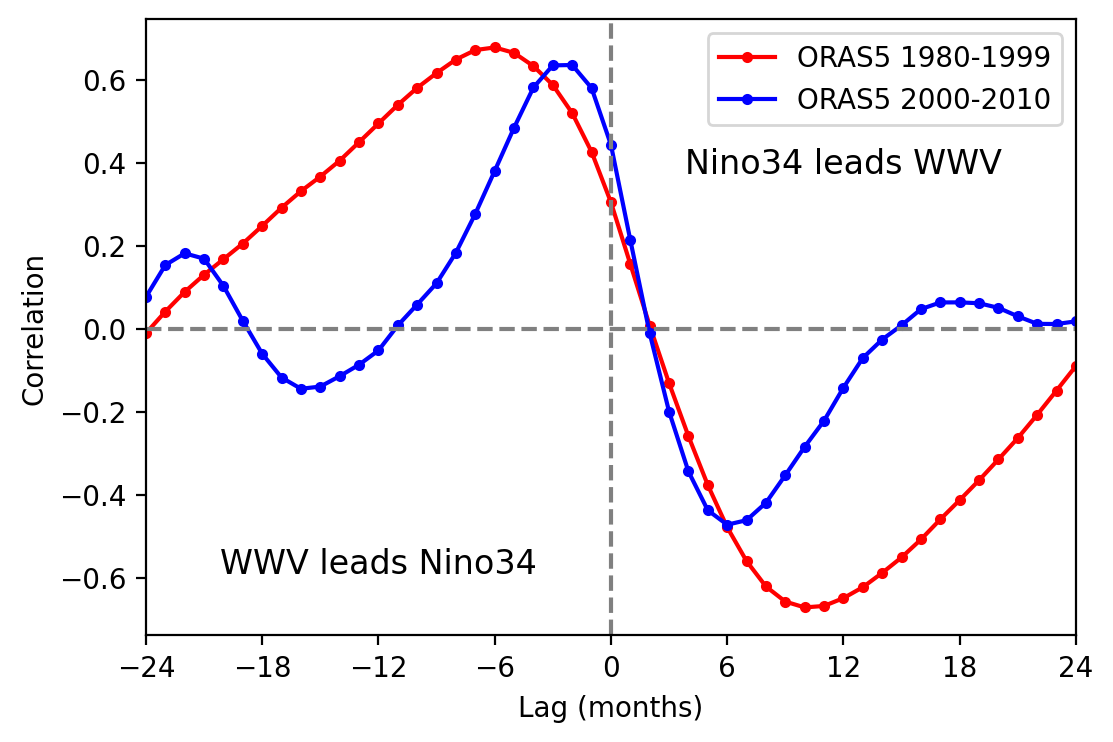

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

slice_P1 = slice('1980-01', '1999-12')
slice_P2 = slice('2000-01', '2010-12')
ccr_obs_P1 = xcorr(obs_RO_ds.sel(time=slice_P1), obs_RO_ds['Nino34'].sel(time=slice_P1), maxlags=36)
ccr_obs_P2 = xcorr(obs_RO_ds.sel(time=slice_P2), obs_RO_ds['Nino34'].sel(time=slice_P2), maxlags=36)

sel_var = 'WWV'
ax.plot(ccr_obs_P1.lag, ccr_obs_P1[sel_var], c='red', marker='.', label=f'ORAS5 {slice_P1.start[0:4]}-{slice_P1.stop[0:4]}')
ax.plot(ccr_obs_P2.lag, ccr_obs_P2[sel_var], c='blue', marker='.', label=f'ORAS5 {slice_P2.start[0:4]}-{slice_P2.stop[0:4]}')

ax.set_ylabel('Correlation')
ax.set_xlabel('Lag (months)')
ax.set_xticks(np.arange(-36, 37, step=6))
ax.text(0.25, 0.1,'WWV leads Nino34', ha='center', transform=ax.transAxes, fontsize='large')
ax.text(0.75, 0.75,'Nino34 leads WWV', ha='center', transform=ax.transAxes, fontsize='large')
ax.set_xlim([-24, 24])
ax.axhline(0, ls='--', c='gray')
ax.axvline(0, ls='--', c='gray')
ax.legend()

### 1.5 ENSO spectrum analysis

Thomson’s multitaper power spectral density (PSD) estimate
See pmtm in `XRO_utils.py`

**Combination mode**

Stuecker, M. F., Timmermann, A., Jin, F.-F., McGregor, S., & Ren, H.-L. (2013). A combination mode of the annual cycle and the El Niño/Southern Oscillation. Nature Geoscience, 6(7), 540–544. https://doi.org/10.1038/ngeo1826


In [10]:
psd_obs, psd_sig_obs, psd_ci_obs = pmtm( obs_RO_ds['Nino34'], dim='time', dt=1/12, nw=5)
print(psd_obs.coords)

Coordinates:
  * freq     (freq) float64 0.0 0.02174 0.04348 0.06522 ... 5.957 5.978 6.0


Text(0.5, 1.0, 'Spectrum of Niño3.4 SST anomaly')

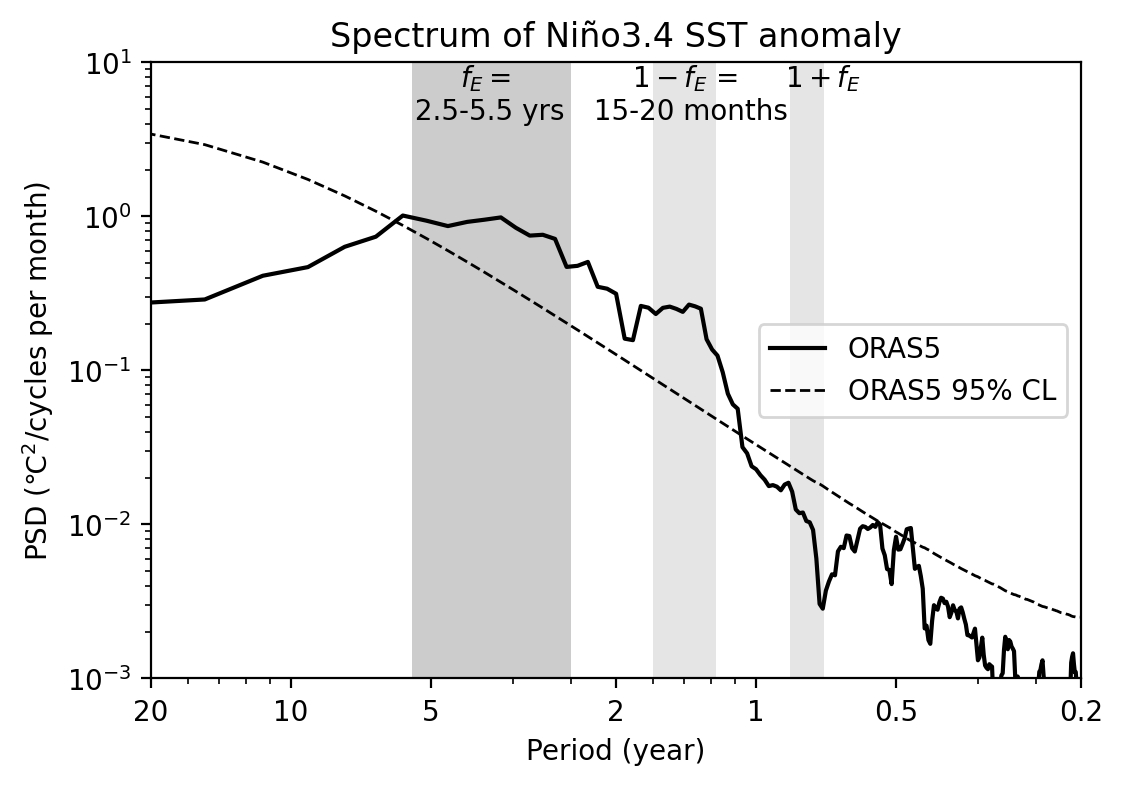

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.loglog(psd_obs.freq, psd_obs, lw=1.5, color='k', label='ORAS5')
ax.plot(psd_sig_obs.freq, psd_sig_obs, lw=1., color='k', linestyle='--', label='ORAS5 95% CL')

per = [50,20,10,5,2,1,0.5,0.2]
xt = 1.0/np.array(per)
ax.set_xticks(xt)
ax.set_xticklabels(map(str, per))
ax.set_ylabel('PSD (℃$^2$/cycles per month)')
ax.set_xlabel('Period (year)')
ax.set_xlim([1/20, 5])
ax.set_ylim([1e-3, 10])

ax.legend(loc='right')

y_min, y_max = ax.get_ylim()
Mfreq_enso = np.array([1/2.5, 1/5.5])
Mfreq_fplus = 1 + Mfreq_enso
Mfreq_fmins = 1 - Mfreq_enso

ax.fill_between(Mfreq_enso, y_min, y_max, fc='gray', alpha=0.4)
ax.fill_between(Mfreq_fplus, y_min, y_max, fc='gray',  alpha=0.2)
ax.fill_between(Mfreq_fmins, y_min, y_max, fc='gray', alpha=0.2)

ax.text(np.mean(Mfreq_enso)*0.9, y_max, '$f_{E}=$\n 2.5-5.5 yrs', ha='center', va='top')
ax.text(np.mean(Mfreq_fplus)+0.1, y_max, '$1+f_{E}$', ha='center', va='top')

ax.text(np.mean(Mfreq_fmins), y_max, '$1-f_{E}$ = \n 15-20 months', ha='center', va='top')
ax.set_title('Spectrum of Niño3.4 SST anomaly')

## 2. RO equations and its forms in XRO/CRO framework

### 2.1 Master RO equations

$$
\frac{dT}{dt} = R T + F_1 h + b_{T} T^2 - c_{T} T^3 + d_{T} T H + \sigma_T (1+B*H(T)*T)\xi_T
$$

$$
\frac{dh}{dt} = -\varepsilon h - F_2 T - b_h T^2 + \sigma_h \xi_h
$$

Two indices are used to describe the oscillatory behaviour of ENSO. 
 - **$T$**: Sea surface temperature (SST) anomalies averaged over the Niño3.4 region 170°–120° W, 5° S–5° N
 - **$h$** Thermocline depth anomalies averaged over the equatorial Pacific 120° E–80° W, 5° S–5° N, that is, the WWV index (with a constant factor of the area it covers).

<div style="border-left: 4px solid #FFA500; background-color: #FFF3CD; padding: 10px;">
    <strong>Choices of T and h:
    </strong>
    Following Zhao et al. (2024, Nature), we use Nino34 and WWV as ENSO state vectors in this notebook. You are welcome to try different versions and explore the similarities and differences. 
</div>



### 2.2 RO equations in XRO framework

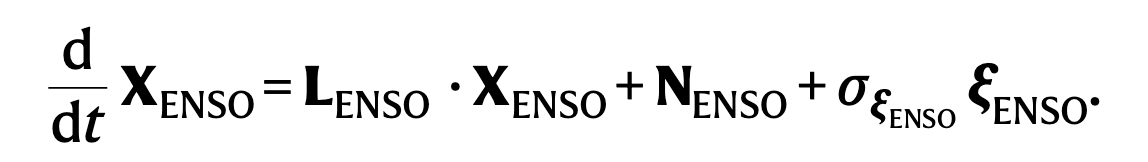

Following Zhao et al. (2024), the standard XRO include the state vectors of ENSO and other climate modes in global oceans.
which includes 

$X_{ENSO}=[T_{ENSO}, WWV]$ 


\begin{pmatrix}
R & F_1 \\
- F_2 & -\varepsilon
\end{pmatrix}

L = 
\begin{pmatrix}
L_{11} & L_{12} \\
L_{21} & L_{22}
\end{pmatrix}


$L_{11} = R$

$L_{12} = F_1$

$L_{21} = -F_2$

$L_{22} = -\varepsilon$





How to fit, simulate and reforecast ENSO with the python `XRO` library.

1) XRO fitting on observation 
3) XRO stochastic simulation
4) XRO determintic reforecasting
5) XRO stochastic reforecasting

This examples may be executed within 5 minutes in a personal computer.

See our paper Zhao et al. 2024[[1]](#1) for details of analysis. If you encounter problems in running `XRO`, please feel free to contact Sen Zhao (zhaos@hawaii.edu).

References:
- Zhao, S., Jin, F.-F., Stuecker, M.F., Thompson, P.R., Kug, J.-S., McPhaden, M.J., Cane, M.A., Wittenberg, A.T., Cai, W.,. Explainable El Niño predictability from climate mode interactions. Nature. https://doi.org/10.1038/s41586-024-07534-6

The XRO model form : dX/dt = L * X + NRO_T + NRO_H + \xi

NRO_T is nonlinear terms in ENSO's T equation
NRO_H is nonlinear terms is ENSO's H equation

**XRO equation forms**

- The standard XRO model in Zhao et al. (2024) is maskb for ENSO's SST and IOD's SST and T*H term in ENSO SST equation, thus `maskb=['IOD']`, `maskNT=['T2', 'TH']`
- The linear form of XRO is setting `maskb=[]` and `maskNT=[]`


In [12]:
XRO_ac2 = XRO(ncycle=12, ac_order=2)
XRO_ac1 = XRO(ncycle=12, ac_order=1)
XRO_ann = XRO(ncycle=12, ac_order=0)

print("All required libraries are installed and imported successfully!")

All required libraries are installed and imported successfully!


## 3. RO stochastic simulations with different complexities

### 3.1 Validating whether the fitted RO model reproduces observed properties
We fitted the RO model with observed Nino34 and WWV indices with full complexities

$$
\frac{dT}{dt} = R T + F_1 h + b_{T} T^2 - c_{T} T^3 + d_{T} T H + \sigma_T (1+B*H(T)*T)\xi_T
$$

$$
\frac{dh}{dt} = -\varepsilon h - F_2 T - b_h T^2 + \sigma_h \xi_h
$$


In [13]:
fit_NRO = XRO_ac2.fit_matrix(obs_RO_ds, maskNT=['T2', 'TH', 'T3'], maskNH=['T2'])
fit_NRO_ds = XRO_ac2.get_RO_parameters(fit_NRO)
fit_NRO_ds/12

print( (obs_RO_ds['Nino34']).mean('time'),
(obs_RO_ds['Nino34']**2).mean('time'),
(obs_RO_ds['Nino34']**3).mean('time'))

<xarray.DataArray 'Nino34' ()>
array(-3.4553418e-09, dtype=float32) <xarray.DataArray 'Nino34' ()>
array(0.8008647, dtype=float32) <xarray.DataArray 'Nino34' ()>
array(0.3580669, dtype=float32)


Text(0.5, 1.0, 'ENSO seasonal synchronization')

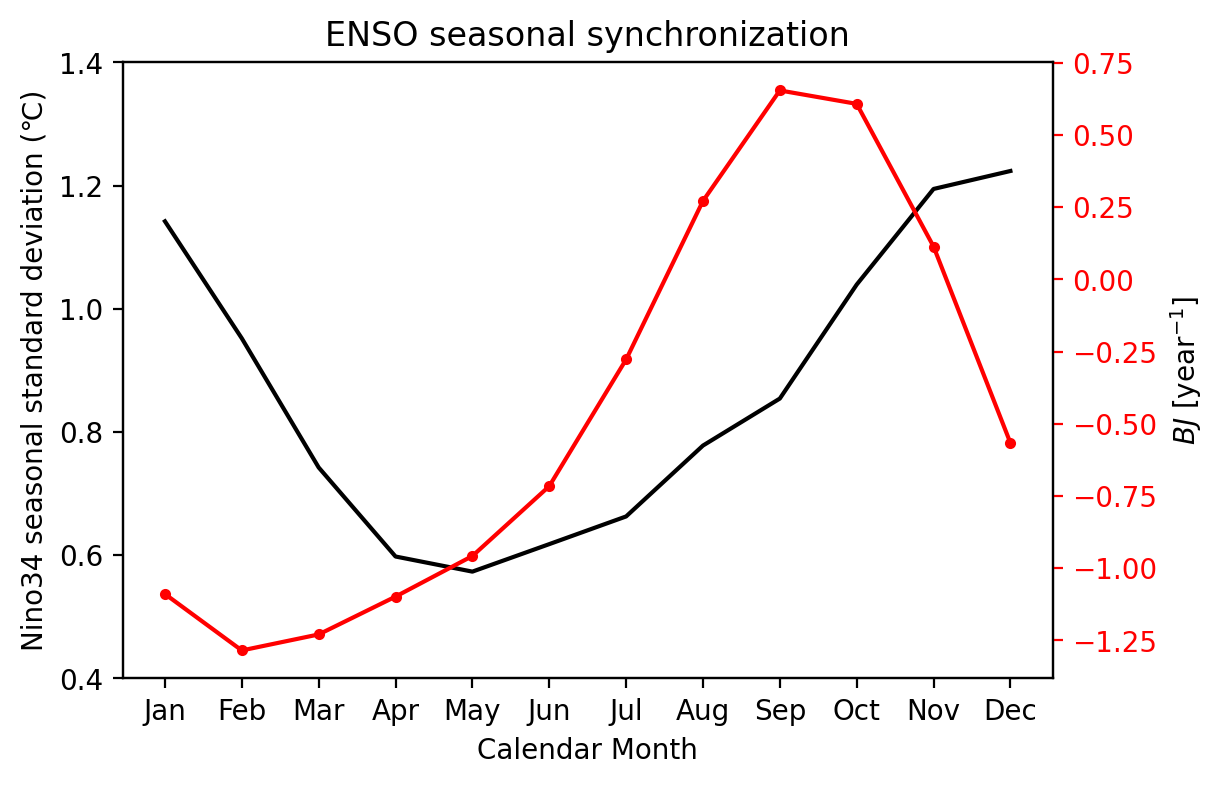

In [14]:
# model with full annual cycle
fit_NRO = XRO_ac2.fit_matrix(obs_RO_ds, maskNT=['T2'], maskNH=['T2'])
# fit_NRO = XRO_ac2.set_NRO_annualmean(fit_NRO)
fit_NRO_ds = XRO_ac2.get_RO_parameters(fit_NRO)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

axR=ax.twinx()
fit_NRO_ds['BJ_ac'].plot(c='red', marker='.', ax=axR)
axR.tick_params(axis='y', colors='red', labelcolor='red')
# axR.set_ylim([-2, 1])

ax.set_xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('Nino34 seasonal standard deviation (℃)')
ax.set_xlabel('Calendar Month')
ax.set_ylim([0.4, 1.4])
ax.set_title('ENSO seasonal synchronization')

In [15]:
fit_NRO_ds/12

<xarray.Dataset>
Dimensions:   (cycle: 12)
Coordinates:
  * cycle     (cycle) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/21)
    R         (cycle) float64 -0.1606 -0.2028 -0.1796 ... 0.04333 -0.0613
    F1        (cycle) float64 0.0006213 0.0006811 0.01073 ... 0.01304 0.007505
    F2        (cycle) float64 1.742 1.56 1.521 1.671 ... 0.4788 1.248 1.723
    epsilon   (cycle) float64 0.02093 0.01131 0.02525 ... 0.02444 0.03309
    xi_T      (cycle) float64 0.1702 0.1671 0.1447 ... 0.1896 0.1621 0.1889
    xi_h      (cycle) float64 1.521 1.598 1.482 1.231 ... 1.232 1.159 1.327 1.51
    ...        ...
    cT_3      (cycle) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    bH_1      (cycle) float64 -0.06695 0.035 -0.005904 ... -0.1658 -0.1747
    bH_2      (cycle) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    cH_1      (cycle) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    cH_2      (cycle) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    cH_3      (cycle) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

`XRO_ac2.simulate`

Stochastic simulations (as an example, initial from observed 1979-01, each model run 100 years with 100 realiazations)

- set `seed` to int number to get the exact same result (default is None)
- set `is_xi_stdac=False` if consider seasonal modulation of noise amplitde (default is None)

The output is archived as monthly mean of state vectors

In [16]:
seed = 100
sim_NRO = XRO_ac2.simulate(fit_ds=fit_NRO, X0_ds=obs_RO_ds.isel(time=0), 
                           nyear=100, ncopy=100, noise_type='red', 
                           seed=seed, is_xi_stdac=False, xi_B=0., is_heaviside=True)

#### Reproduce ENSO irregular interannual oscillations
Show the time series of each member

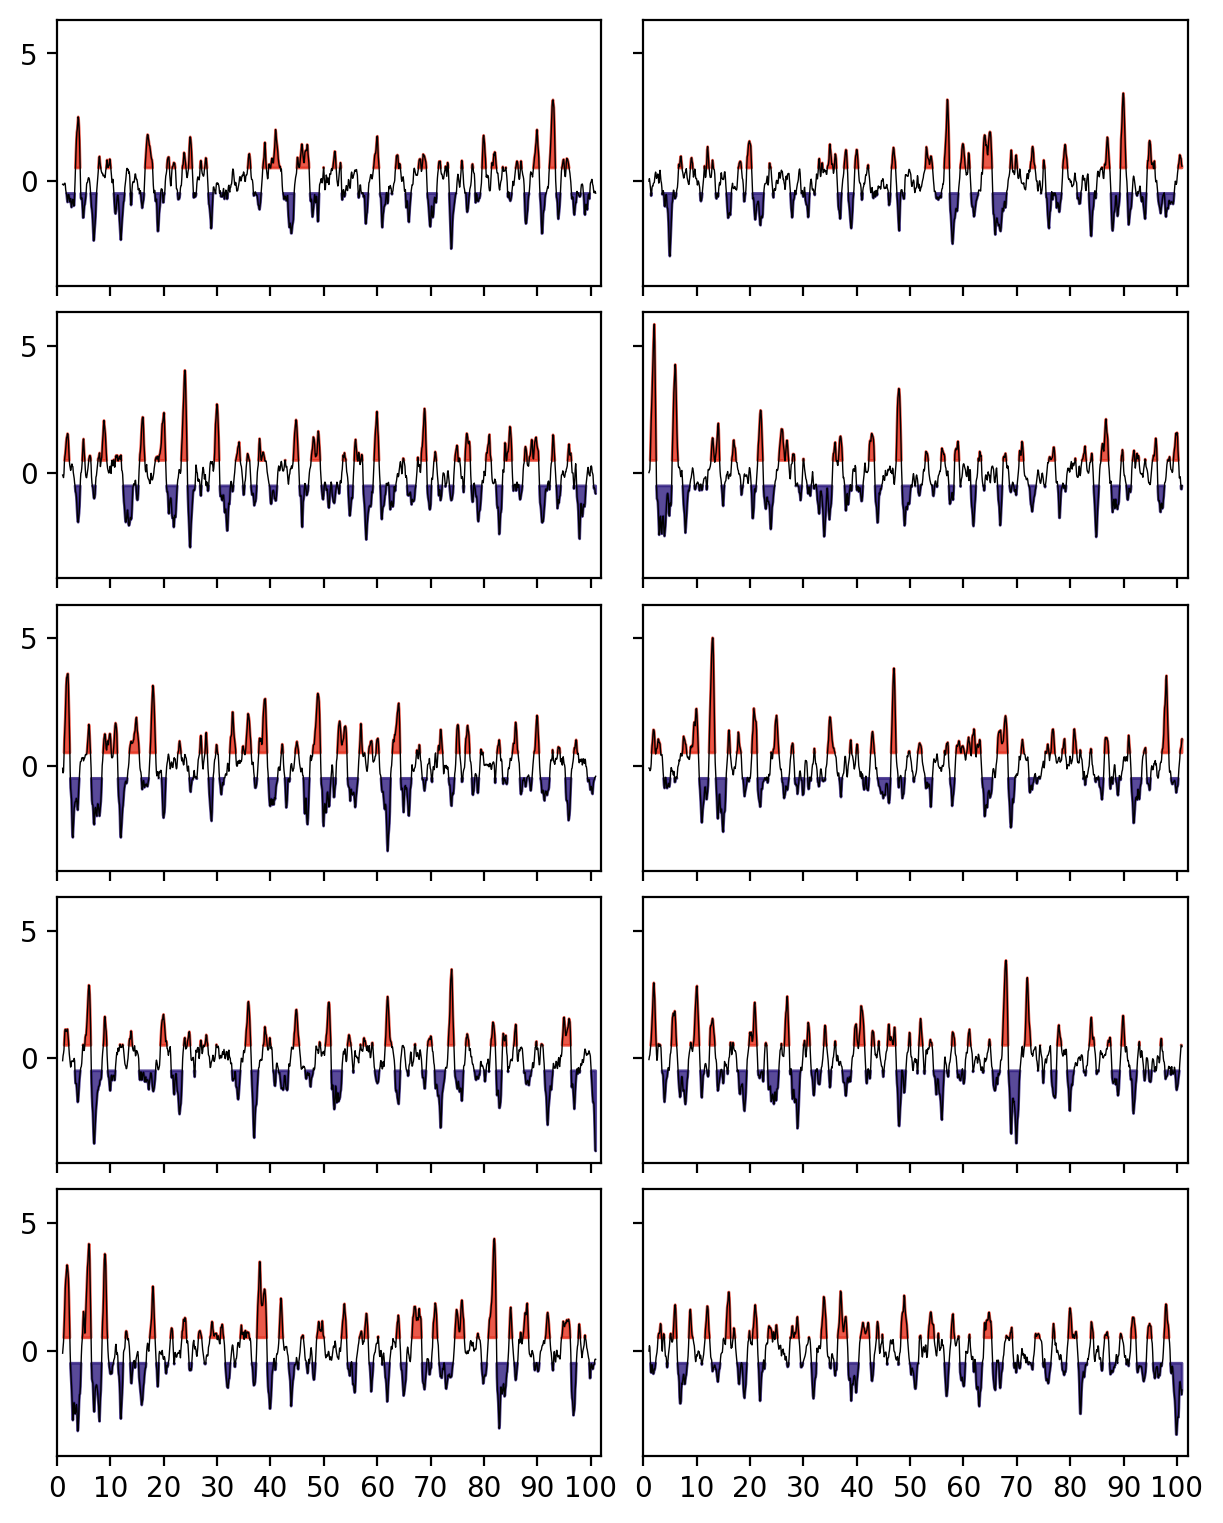

In [42]:
nmember = 10

ncol = 2
nrow = nmember//ncol
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*3, nrow*1.5), sharey=True, sharex=True, layout='compressed')

for i, ax in enumerate(axes.flat):
    plot_above_below_shading(sim_NRO.isel(member=i*2)['Nino34'], c='black', lw=0.5, ax=ax)
    # ax.set_xlabel('Model years')
    ax.set_xlim([1, 102])
    ax.set_xticks(np.arange(0, 101, step=10))

#### Reproduce the observed ENSO seasonal synchronization

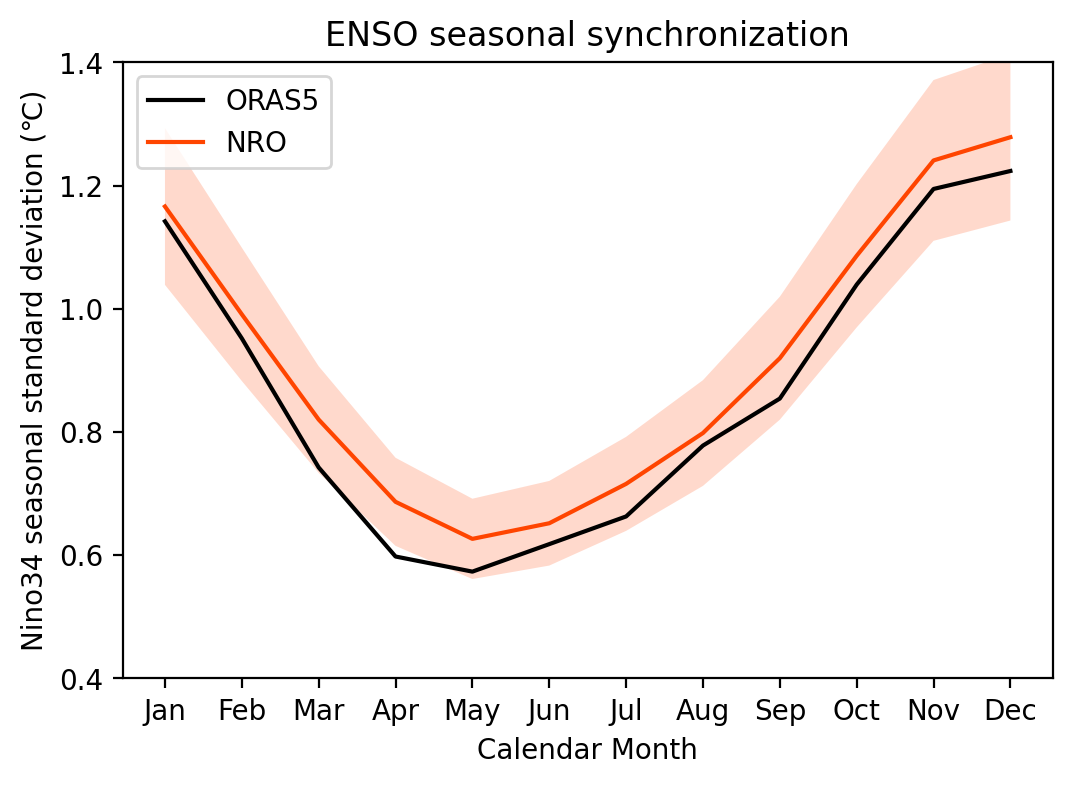

In [18]:
stddevAC_NRO_ds = sim_NRO.groupby('time.month').std('time')


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

plot_fill_between(stddevAC_NRO_ds[sel_var], xtime=x_month, ax=ax, label='NRO')
# axR=ax.twinx()
# fit_NRO_ds['BJ_ac'].plot(c='red', marker='.', ax=axR)
# axR.tick_params(axis='y', colors='red', labelcolor='red')
# # axR.set_ylim([-2, 1])

ax.set_xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('Nino34 seasonal standard deviation (℃)')
ax.set_xlabel('Calendar Month')
ax.set_ylim([0.4, 1.4])
ax.set_title('ENSO seasonal synchronization')
ax.legend()

#### Reproduce the observed ENSO skewness

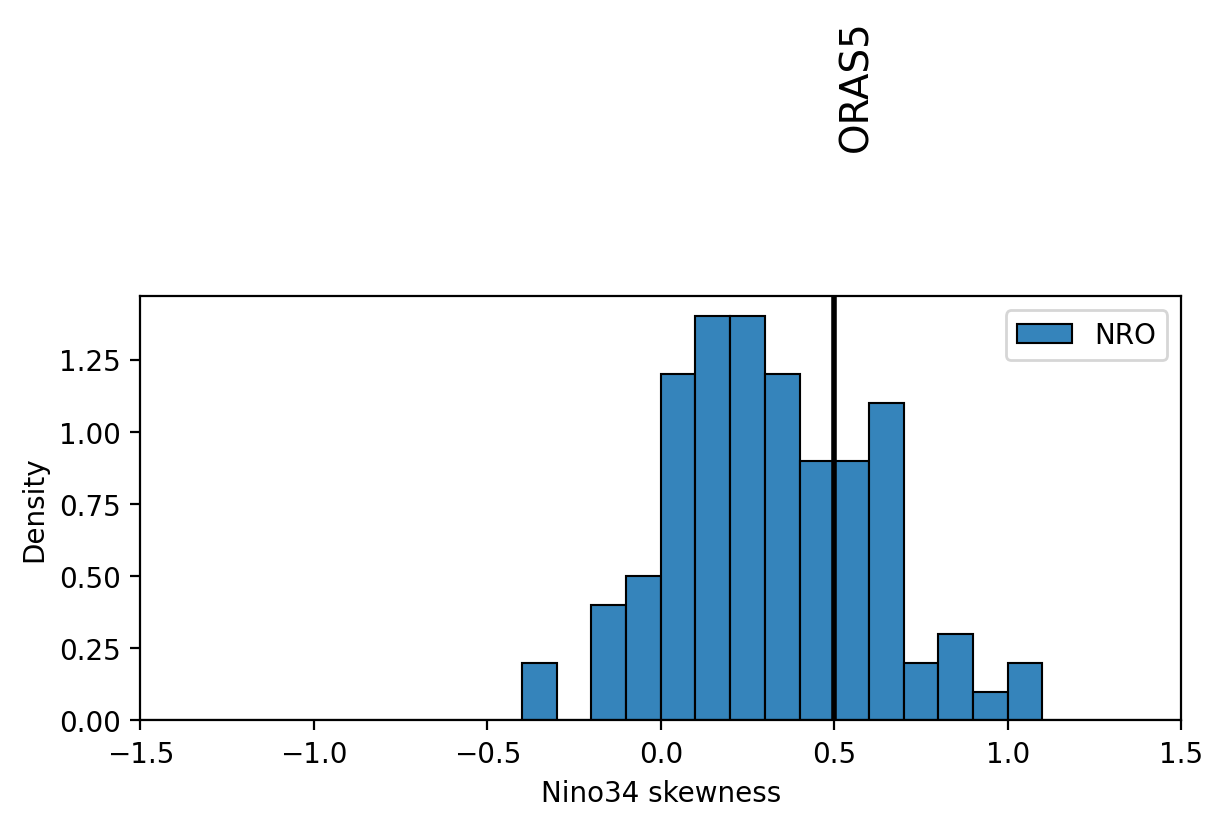

In [19]:
skew_NRO_ds = sim_NRO.skew('time')

sel_var = 'Nino34'
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=True, sharex=True, layout='compressed')

bins = np.arange(-2, 2.01, step=0.1)
model_lists = [skew_NRO_ds]
model_labels = ['NRO']

for i, model_ds  in enumerate(model_lists):
    sns.histplot(model_ds[sel_var], stat='density', bins=bins, ax=ax, alpha=0.9, label=model_labels[i])

ax.axvline(skew_obs_ds[sel_var], c='black', lw=2)
ax.set_xlim([-1.5, 1.5])
ax.set_xlabel(f'{sel_var} skewness')
ax.text( skew_obs_ds[sel_var]+0.01, 2., 'ORAS5', rotation=90, fontsize=14)
ax.legend()

#### Reproduce the observed ENSO SST-WWV relationships

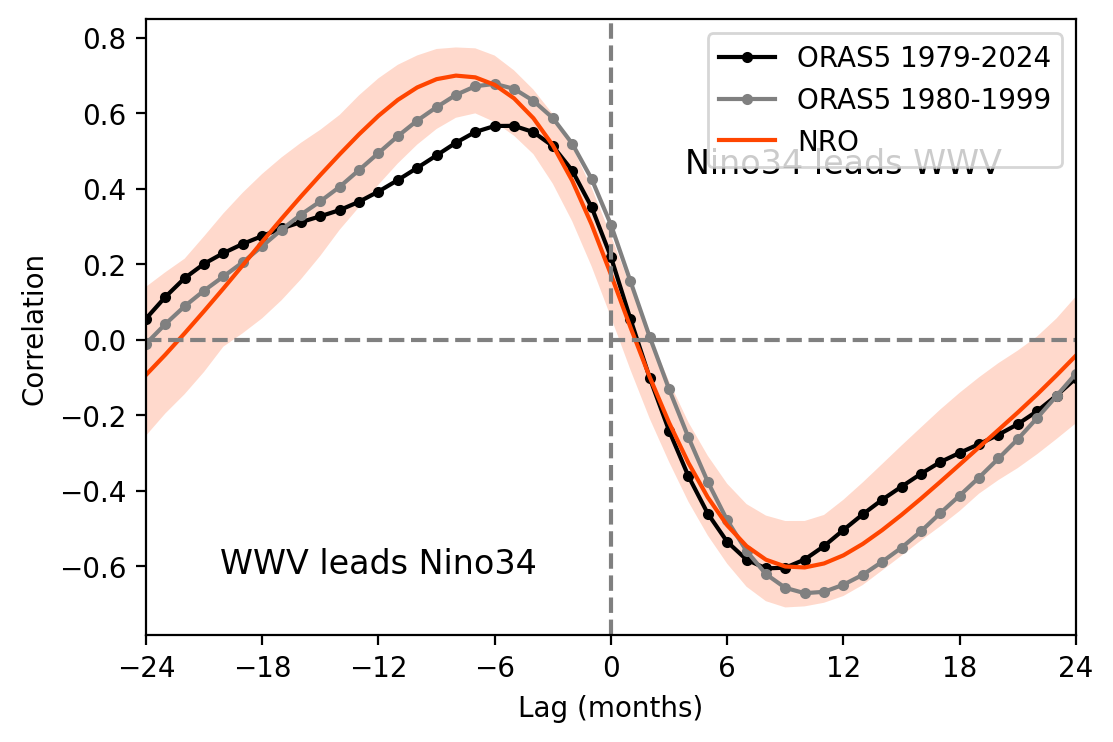

In [20]:
ccr_NRO_ds = xcorr(sim_NRO, sim_NRO['Nino34'], maxlags=36)


fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sel_var = 'WWV'
ax.plot(ccr_obs_ds.lag, ccr_obs_ds[sel_var], c='black', marker='.', label='ORAS5 1979-2024')
ax.plot(ccr_obs_P1.lag, ccr_obs_P1[sel_var], c='gray', marker='.', label=f'ORAS5 {slice_P1.start[0:4]}-{slice_P1.stop[0:4]}')
# ax.plot(ccr_obs_P2.lag, ccr_obs_P2[sel_var], c='blue', marker='.', label=f'ORAS5 {slice_P2.start[0:4]}-{slice_P2.stop[0:4]}')

plot_fill_between(ccr_NRO_ds[sel_var], dim='member', c='orangered',
                  alpha=0.2, xtime=ccr_NRO_ds.lag, ax=ax, option=0, label='NRO')

ax.set_ylabel('Correlation')
ax.set_xlabel('Lag (months)')
ax.set_xticks(np.arange(-36, 37, step=6))
ax.text(0.25, 0.1,'WWV leads Nino34', ha='center', transform=ax.transAxes, fontsize='large')
ax.text(0.75, 0.75,'Nino34 leads WWV', ha='center', transform=ax.transAxes, fontsize='large')
ax.set_xlim([-24, 24])
ax.axhline(0, ls='--', c='gray')
ax.axvline(0, ls='--', c='gray')
ax.legend()

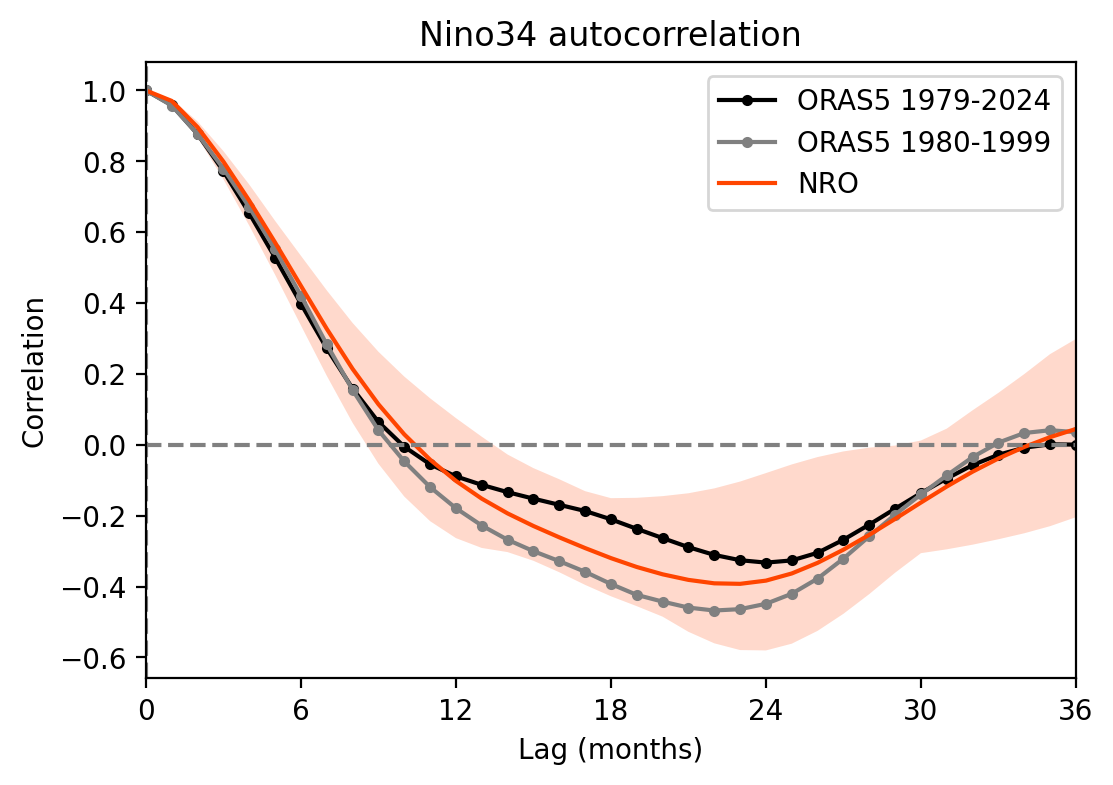

In [21]:

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sel_var = 'Nino34'
ax.plot(ccr_obs_ds.lag, ccr_obs_ds[sel_var], c='black', marker='.', label='ORAS5 1979-2024')
ax.plot(ccr_obs_P1.lag, ccr_obs_P1[sel_var], c='gray', marker='.', label=f'ORAS5 {slice_P1.start[0:4]}-{slice_P1.stop[0:4]}')
# ax.plot(ccr_obs_P2.lag, ccr_obs_P2[sel_var], c='blue', marker='.', label=f'ORAS5 {slice_P2.start[0:4]}-{slice_P2.stop[0:4]}')

plot_fill_between(ccr_NRO_ds[sel_var], dim='member', c='orangered',
                  alpha=0.2, xtime=ccr_NRO_ds.lag, ax=ax, option=0, label='NRO')

ax.set_title('Nino34 autocorrelation')
ax.set_ylabel('Correlation')
ax.set_xlabel('Lag (months)')
ax.set_xticks(np.arange(-36, 37, step=6))
ax.set_xlim([0, 36])
ax.axhline(0, ls='--', c='gray')
ax.axvline(0, ls='--', c='gray')
ax.legend()

#### Reproduce the observed ENSO spectrum

Text(0.5, 1.0, 'Spectrum of Niño3.4 SST anomaly')

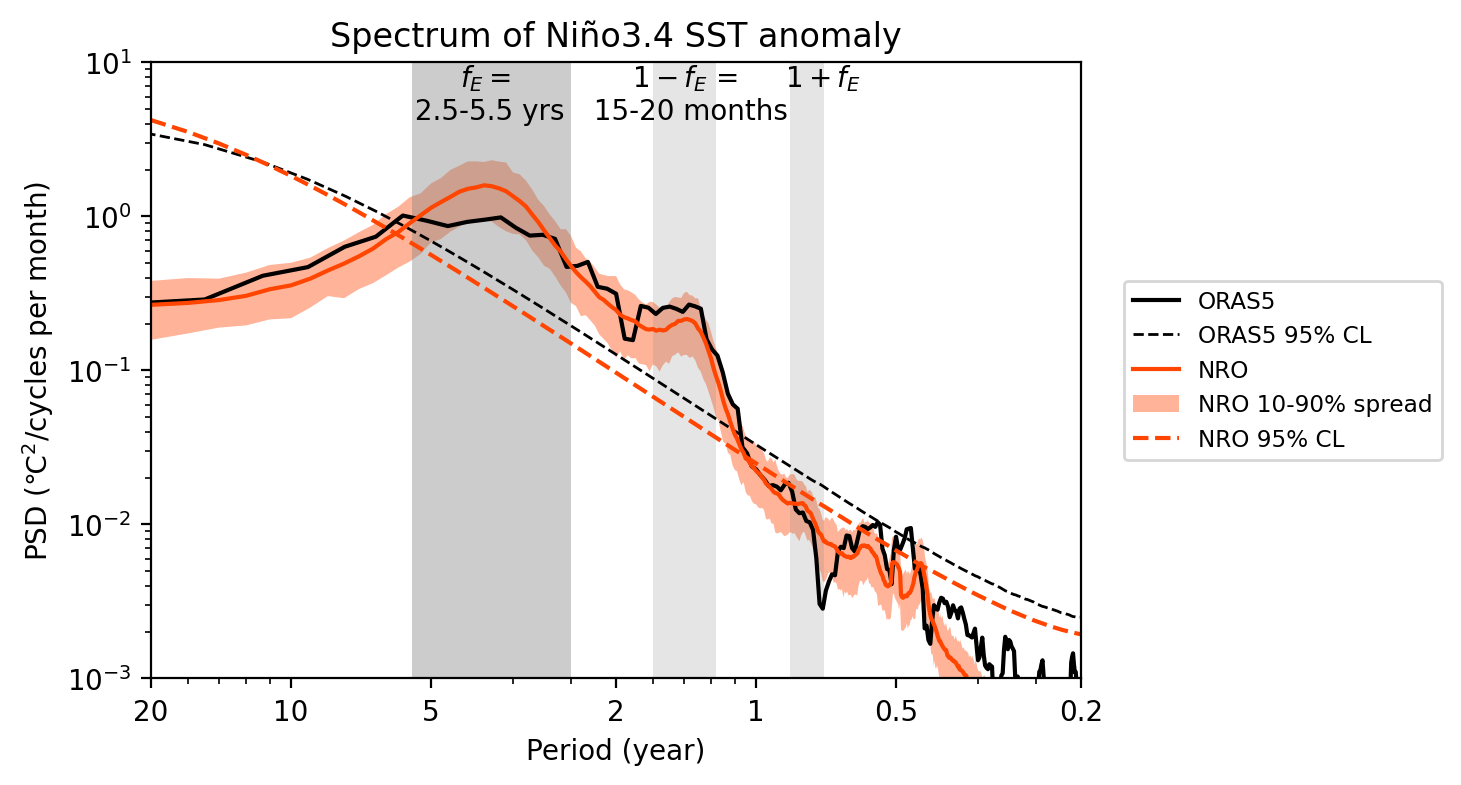

In [22]:
psd_NRO, psd_sig_NRO, psd_ci_NRO = pmtm( sim_NRO['Nino34'], dim='time', dt=1/12, nw=5)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.loglog(psd_obs.freq, psd_obs, lw=1.5, color='k', label='ORAS5')
ax.plot(psd_sig_obs.freq, psd_sig_obs, lw=1., color='k', linestyle='--', label='ORAS5 95% CL')

ax.loglog(psd_NRO.freq, psd_NRO.mean('member'), lw=1.5, color='orangered', label='NRO')
ax.fill_between(psd_NRO.freq, psd_NRO.quantile(0.1, dim='member'), 
                psd_NRO.quantile(0.9, dim='member'), fc='orangered', label='NRO 10-90% spread', alpha=0.4)
ax.semilogx(psd_sig_NRO.freq, psd_sig_NRO.mean('member'), color='orangered', linestyle='--', label='NRO 95% CL')

per = [50,20,10,5,2,1,0.5,0.2]
xt = 1.0/np.array(per)
ax.set_xticks(xt)
ax.set_xticklabels(map(str, per))
ax.set_ylabel('PSD (℃$^2$/cycles per month)')
ax.set_xlabel('Period (year)')
ax.set_xlim([1/20, 5])
ax.set_ylim([1e-3, 10])

ax.legend(loc='center right', fontsize='small', bbox_to_anchor=(1.4, 0.5))

y_min, y_max = ax.get_ylim()
Mfreq_enso = np.array([1/2.5, 1/5.5])
Mfreq_fplus = 1 + Mfreq_enso
Mfreq_fmins = 1 - Mfreq_enso

ax.fill_between(Mfreq_enso, y_min, y_max, fc='gray', alpha=0.4)
ax.fill_between(Mfreq_fplus, y_min, y_max, fc='gray',  alpha=0.2)
ax.fill_between(Mfreq_fmins, y_min, y_max, fc='gray', alpha=0.2)

ax.text(np.mean(Mfreq_enso)*0.9, y_max, '$f_{E}=$\n 2.5-5.5 yrs', ha='center', va='top')
ax.text(np.mean(Mfreq_fplus)+0.1, y_max, '$1+f_{E}$', ha='center', va='top')

ax.text(np.mean(Mfreq_fmins), y_max, '$1-f_{E}$ = \n 15-20 months', ha='center', va='top')
ax.set_title('Spectrum of Niño3.4 SST anomaly')

### 3.2 ENSO seasonal phase locking & sensitivity to parameters (R’s seasonal cycle)

In the following code block, we calcualte the Nino34 seasonal standard deviation (stddev) for observation (ORAS5), XRO control simulation, and XRO(ac=0) simulation.

- As shown in the figure, XRO accurately simulates observed ENSO seasonal synchronization (comoare black curve and red curve)
- If we don't include the seasonal cycle in the XRO operators, there is no seasonal synchronization (blue curve)

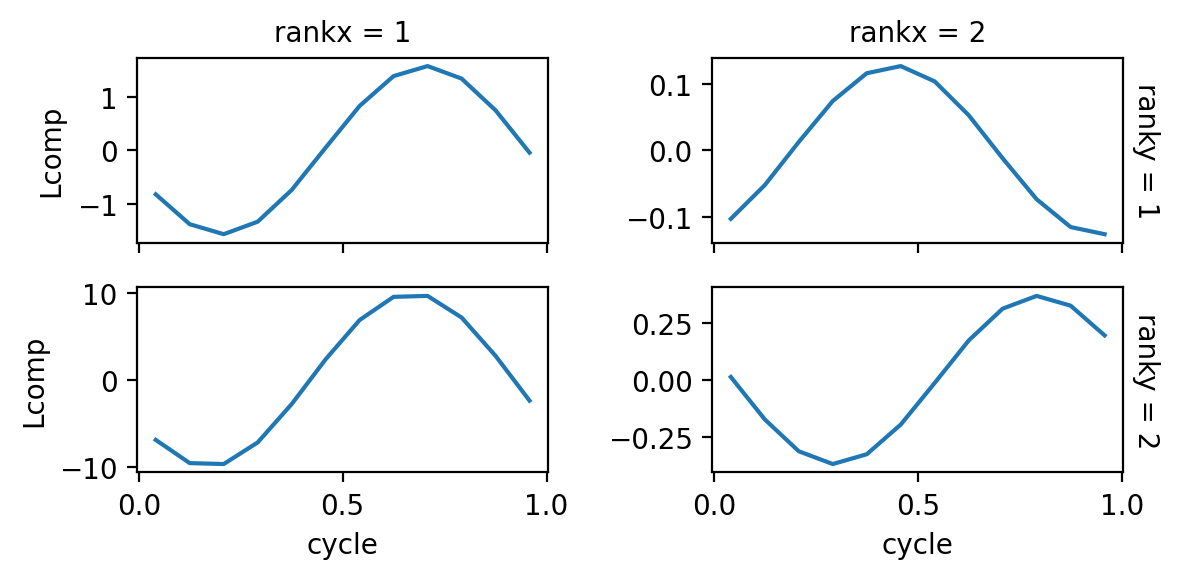

In [23]:
fit_NRO['Lcomp'].sel(ac_rank=1).plot(col='rankx', row='ranky', sharey=False, sharex=True, figsize=(6, 3))

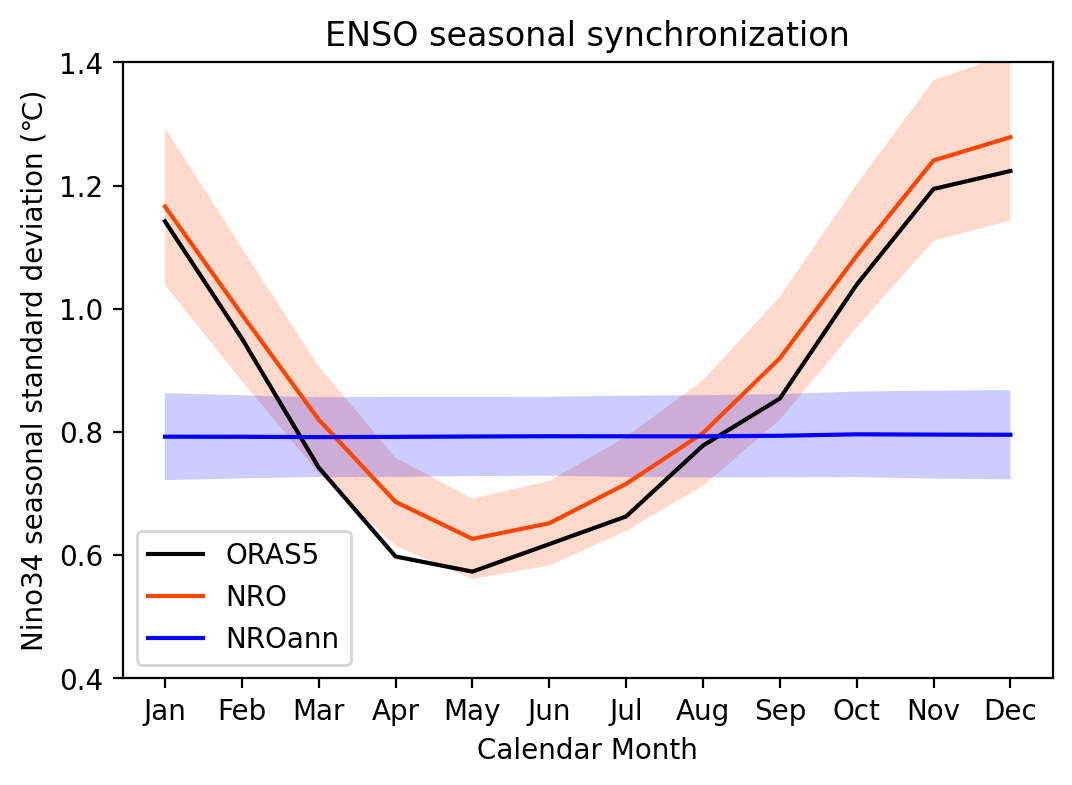

In [24]:
# model with full annual cycle
# fit_NROann = XRO_ann.fit_matrix(obs_RO_ds, maskNT=['T2'], maskNH=['T2'])

fit_NROann = fit_NRO.copy(deep=True)

fit_NROann['Lac'] = fit_NRO['Lcomp'].sel(ac_rank=0)
fit_NROann = XRO_ann.set_NRO_annualmean(fit_NROann)

fit_NROann_ds = XRO_ann.get_RO_parameters(fit_NRO)

seed = 1000
sim_NROann = XRO_ac2.simulate(fit_ds=fit_NROann, X0_ds=obs_RO_ds.isel(time=0), 
                           nyear=100, ncopy=100, noise_type='red', 
                           seed=seed, is_xi_stdac=False, xi_B=0., is_heaviside=True)  

stddevAC_NROann_ds = sim_NROann.groupby('time.month').std('time')


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

plot_fill_between(stddevAC_NRO_ds[sel_var], xtime=x_month, ax=ax, label='NRO')
plot_fill_between(stddevAC_NROann_ds[sel_var], xtime=x_month, ax=ax, c='blue', label='NROann')
# axR=ax.twinx()
# fit_NRO_ds['BJ_ac'].plot(c='red', marker='.', ax=axR)
# axR.tick_params(axis='y', colors='red', labelcolor='red')
# # axR.set_ylim([-2, 1])

ax.set_xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('Nino34 seasonal standard deviation (℃)')
ax.set_xlabel('Calendar Month')
ax.set_ylim([0.4, 1.4])
ax.set_title('ENSO seasonal synchronization')
ax.legend()

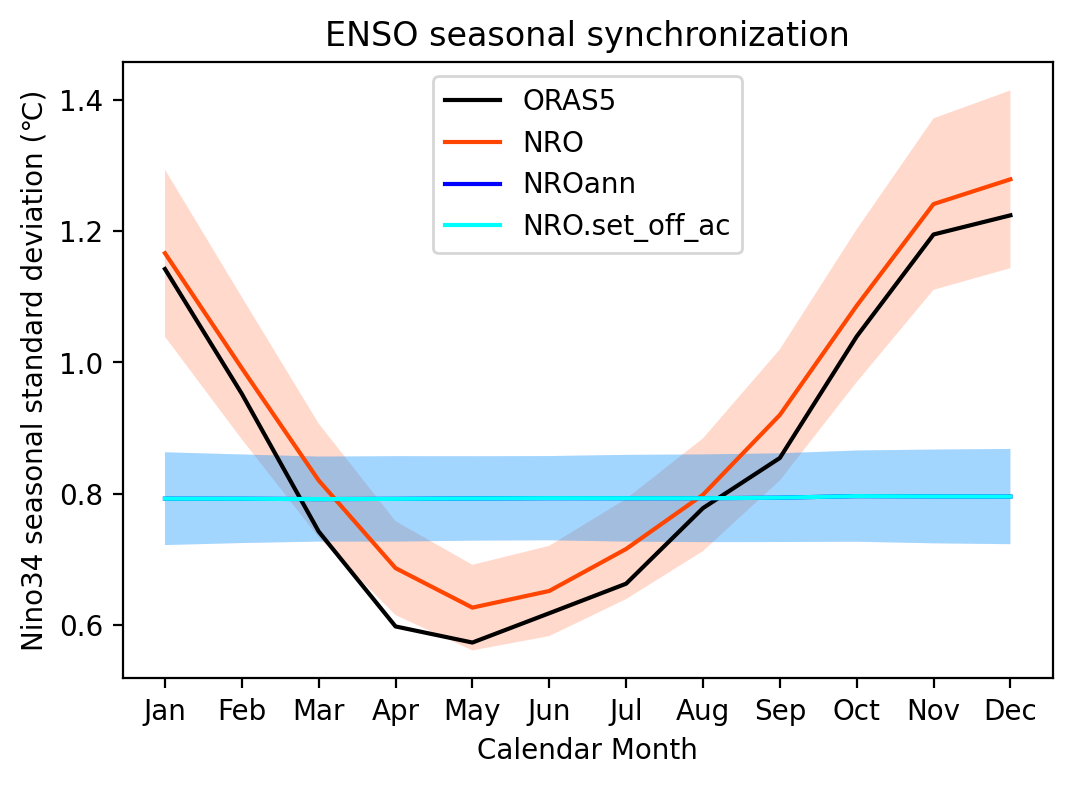

In [25]:
# model with full annual cycle
fit_NROacoff = fit_NRO.copy(deep=True)

# R
fit_NROacoff['Lac'].loc[dict(rankx=1, ranky=1)] = fit_NROann['Lac'].loc[dict(rankx=1, ranky=1)]

# F1
fit_NROacoff['Lac'].loc[dict(rankx=2, ranky=1)] = fit_NROann['Lac'].loc[dict(rankx=2, ranky=1)]

# F2
fit_NROacoff['Lac'].loc[dict(rankx=1, ranky=2)] = fit_NROann['Lac'].loc[dict(rankx=1, ranky=2)]

# epsilon
fit_NROacoff['Lac'].loc[dict(rankx=2, ranky=2)] = fit_NROann['Lac'].loc[dict(rankx=2, ranky=2)]

# nonlinear parameters
fit_NROacoff = XRO_ann.set_NRO_annualmean(fit_NROacoff)


seed = 1000
sim_NROacoff = XRO_ann.simulate(fit_ds=fit_NROacoff, X0_ds=obs_RO_ds.isel(time=0), 
                           nyear=100, ncopy=100, noise_type='red', 
                           seed=seed, is_xi_stdac=False, xi_B=0., is_heaviside=True)  

stddevAC_NROacoff_ds = sim_NROacoff.groupby('time.month').std('time')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sel_var = 'Nino34'
x_month = range(1, 13)
ax.plot(x_month, stddevAC_obs_ds[sel_var], c='black', label='ORAS5')

plot_fill_between(stddevAC_NRO_ds[sel_var], xtime=x_month, ax=ax, label='NRO')
plot_fill_between(stddevAC_NROann_ds[sel_var], xtime=x_month, ax=ax, c='blue', label='NROann')
plot_fill_between(stddevAC_NROacoff_ds[sel_var], xtime=x_month, ax=ax, c='cyan', label='NRO.set_off_ac')
# axR=ax.twinx()
# fit_NRO_ds['BJ_ac'].plot(c='red', marker='.', ax=axR)
# axR.tick_params(axis='y', colors='red', labelcolor='red')
# # axR.set_ylim([-2, 1])

ax.set_xticks(x_month, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel('Nino34 seasonal standard deviation (℃)')
ax.set_xlabel('Calendar Month')
# ax.set_ylim([0.4, 1.8])
ax.set_title('ENSO seasonal synchronization')
ax.legend()

### 3.3 ENSO asymmetry & sensitivity to parameters (b, B) (10 min)

In [26]:
seed = 2000

for B_value in [0, 0.2, 0.4, 0.6, 0.8]:
    fit_NRO = XRO_ac2.fit_matrix(obs_RO_ds, maskNT=['T2'], maskNH=[])

    sim_NRO_senB = XRO_ac2.simulate(fit_ds=fit_NRO, X0_ds=obs_RO_ds.isel(time=0), 
                               nyear=100, ncopy=100, noise_type='white', 
                               seed=seed, is_xi_stdac=False, xi_B=B_value, is_heaviside=False)  
    
    print( f"B={B_value}, SST skewness = {sim_NRO_senB['Nino34'].skew('time').mean('member').values:.2f} +/- {sim_NRO_senB['Nino34'].skew('time').std('member').values:.2f}")

    print( f"B={B_value}, SST stddev = {sim_NRO_senB['Nino34'].std('time').mean('member').values:.2f} +/- {sim_NRO_senB['Nino34'].std('time').std('member').values:.2f}")

B=0, SST skewness = 0.45 +/- 0.25
B=0, SST stddev = 0.79 +/- 0.07
B=0.2, SST skewness = 0.62 +/- 0.32
B=0.2, SST stddev = 0.81 +/- 0.08
B=0.4, SST skewness = 0.81 +/- 0.45
B=0.4, SST stddev = 0.84 +/- 0.11
B=0.6, SST skewness = 1.03 +/- 0.73
B=0.6, SST stddev = 0.90 +/- 0.18
B=0.8, SST skewness = 1.39 +/- 1.86
B=0.8, SST stddev = 1.01 +/- 0.62


### 3.4 ENSO spectrum, auto-correlation, SST-WWV relationships & sensitivity to parameters (F₁, F₂, R, ε) (10 min)


Here we include two versions of XRO model:
    - XRO model with annual mean, annual cycle, and semi-annual cycles components (XROac2)
    - XRO model with annual mean component only (XROac0)
Notes:
1. The monthly time series is used to train the XRO model, so we set `ncycle=12`. Therefore, the XRO simulate/reforecast output is also monthly mean time series.
2. It should be noted that the XRO accept higher resolution data such as (ncycle=52 for weekly data and ncycle=365 for daily data), similarly the output of simulate/reforecast will be weakly or daily automatically.

In [27]:
def calculate_BWJ(fit_ds):
    BJ = 0.5 * ( fit_ds['R'] - fit_ds['epsilon'] )
    WF = np.sqrt( fit_ds['F1'] * fit_ds['F2'] - ( fit_ds['R'] + fit_ds['epsilon'] )**2/4 )
    WJ = np.pi*2/np.sqrt( fit_ds['F1'] * fit_ds['F2'] - ( fit_ds['R'] + fit_ds['epsilon'] )**2/4 )
    out_ds = xr.Dataset({'BJ': BJ, 'WF': WF, 'WJ': WJ})
    out_ds['BJ'].attrs['units'] = 'year**-1'
    out_ds['WF'].attrs['units'] = 'year**-1'
    out_ds['WJ'].attrs['units'] = 'year'
    return out_ds

# linear RO
fit_LRO = XRO_ann.fit_matrix(obs_RO_ds, maskNT=[], maskNH=[])
fit_LRO_ds = XRO_ann.get_RO_parameters(fit_LRO)
fit_LRO_BWJ_ds = calculate_BWJ(fit_LRO_ds.mean('cycle'))
print(fit_LRO_BWJ_ds)

sim_LRO = XRO_ann.simulate(fit_ds=fit_LRO, X0_ds=obs_RO_ds.isel(time=0), 
                           nyear=100, ncopy=100, noise_type='red', 
                           seed=seed, is_xi_stdac=False, xi_B=0., is_heaviside=True)
psd_LRO, psd_sig_LRO, psd_ci_LRO = pmtm( sim_LRO['Nino34'], dim='time', dt=1/12, nw=5)
ccr_LRO_ds = xcorr(sim_LRO, sim_LRO['Nino34'], maxlags=36)

#
# model with full annual cycle
fit_LROsens = fit_LRO.copy(deep=True)

# ## R
fit_LROsens['Lac'].loc[dict(rankx=1, ranky=1)] = fit_LRO['Lac'].loc[dict(rankx=1, ranky=1)] 

# F1
fit_LROsens['Lac'].loc[dict(rankx=2, ranky=1)] = fit_LRO['Lac'].loc[dict(rankx=2, ranky=1)] * 2

# F2
fit_LROsens['Lac'].loc[dict(rankx=1, ranky=2)] = fit_LRO['Lac'].loc[dict(rankx=1, ranky=2)] 

# # epsilon
fit_LROsens['Lac'].loc[dict(rankx=2, ranky=2)] = fit_LRO['Lac'].loc[dict(rankx=2, ranky=2)] 

fit_LROsens_ds = XRO_ann.get_RO_parameters(fit_LROsens)
fit_LROsens_BWJ_ds = calculate_BWJ(fit_LROsens_ds.mean('cycle'))
print(fit_LROsens_BWJ_ds)

sim_LROsens = XRO_ann.simulate(fit_ds=fit_LROsens, X0_ds=obs_RO_ds.isel(time=0), 
                           nyear=100, ncopy=100, noise_type='red', 
                           seed=seed, is_xi_stdac=False, xi_B=0., is_heaviside=True)

psd_LROsens, psd_sig_LROsens, psd_ci_LROsens = pmtm( sim_LROsens['Nino34'], dim='time', dt=1/12, nw=5)
ccr_LROsens_ds = xcorr(sim_LROsens, sim_LROsens['Nino34'], maxlags=36)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    BJ       float64 -0.477
    WF       float64 1.819
    WJ       float64 3.454
<xarray.Dataset>
Dimensions:  ()
Data variables:
    BJ       float64 -0.477
    WF       float64 2.606
    WJ       float64 2.411


Text(0.5, 1.0, 'Spectrum of Niño3.4 SST anomaly')

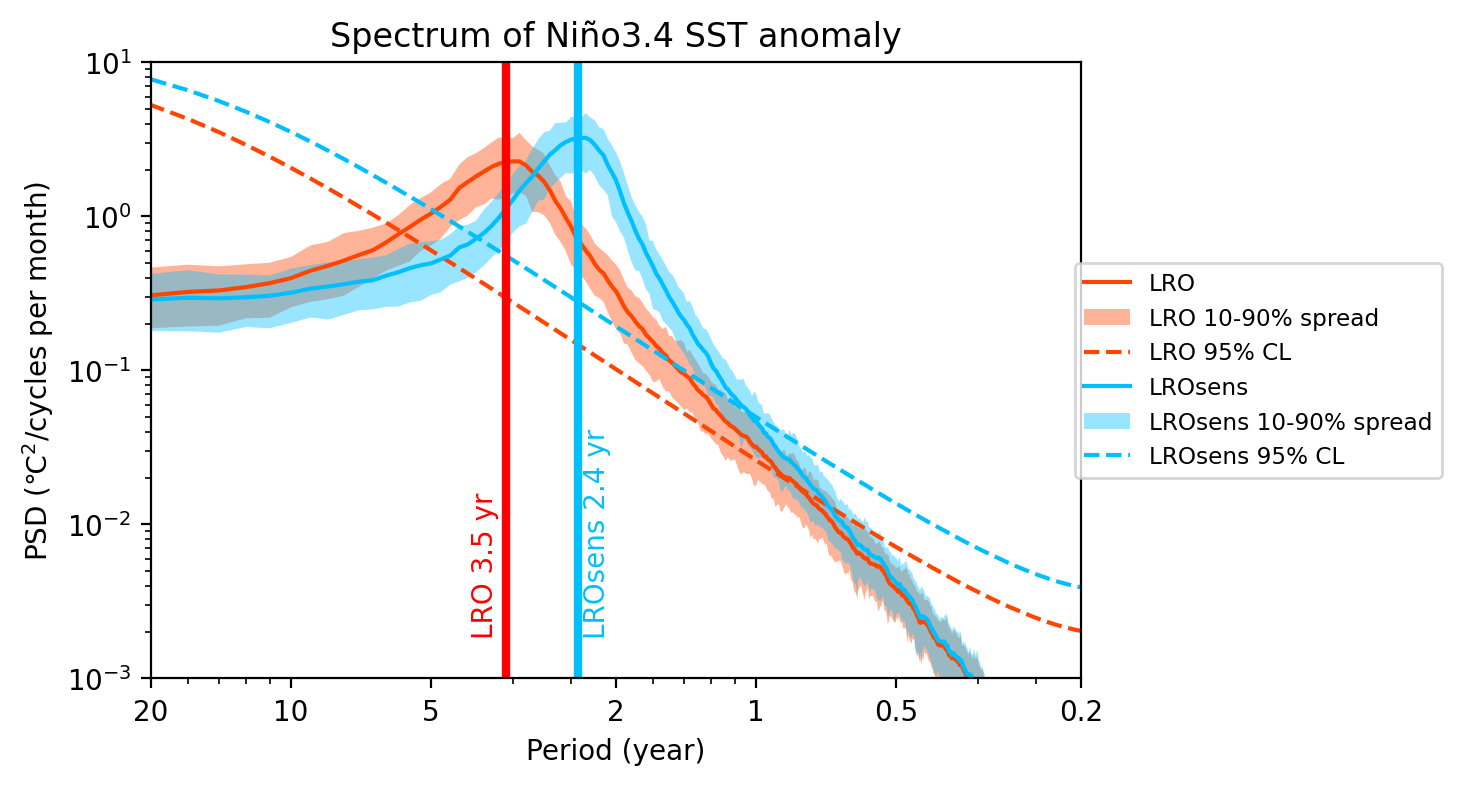

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.loglog(psd_LRO.freq, psd_LRO.mean('member'), lw=1.5, color='orangered', label='LRO')
ax.fill_between(psd_LRO.freq, psd_LRO.quantile(0.1, dim='member'), 
                psd_LRO.quantile(0.9, dim='member'), fc='orangered', label='LRO 10-90% spread', alpha=0.4)
ax.semilogx(psd_sig_LRO.freq, psd_sig_LRO.mean('member'), color='orangered', linestyle='--', label='LRO 95% CL')


ax.loglog(psd_LROsens.freq, psd_LROsens.mean('member'), lw=1.5, color='deepskyblue', label='LROsens')
ax.fill_between(psd_LROsens.freq, psd_LROsens.quantile(0.1, dim='member'), 
                psd_LROsens.quantile(0.9, dim='member'), fc='deepskyblue', label='LROsens 10-90% spread', alpha=0.4)
ax.semilogx(psd_sig_LROsens.freq, psd_sig_LROsens.mean('member'), color='deepskyblue', linestyle='--', label='LROsens 95% CL')

per = [50,20,10,5,2,1,0.5,0.2]
xt = 1.0/np.array(per)
ax.set_xticks(xt)
ax.set_xticklabels(map(str, per))
ax.set_ylabel('PSD (℃$^2$/cycles per month)')
ax.set_xlabel('Period (year)')
ax.set_xlim([1/20, 5])
ax.set_ylim([1e-3, 10])

ax.axvline(1/fit_LRO_BWJ_ds['WJ'].values, c='red', lw=3)
ax.text(1/fit_LRO_BWJ_ds['WJ'].values-0.01, 2e-3, f"LRO {fit_LRO_BWJ_ds['WJ'].values:.1f} yr", c='red', ha='right', rotation=90)

ax.axvline(1/fit_LROsens_BWJ_ds['WJ'].values, c='deepskyblue', lw=3)
ax.text(1/fit_LROsens_BWJ_ds['WJ'].values+0.01, 2e-3, f"LROsens {fit_LROsens_BWJ_ds['WJ'].values:.1f} yr", c='deepskyblue', ha='left', rotation=90)


ax.legend(loc='center right', fontsize='small', bbox_to_anchor=(1.4, 0.5))

# y_min, y_max = ax.get_ylim()
# Mfreq_enso = np.array([1/2.5, 1/5.5])
# Mfreq_fplus = 1 + Mfreq_enso
# Mfreq_fmins = 1 - Mfreq_enso

# ax.fill_between(Mfreq_enso, y_min, y_max, fc='gray', alpha=0.4)
# ax.fill_between(Mfreq_fplus, y_min, y_max, fc='gray',  alpha=0.2)
# ax.fill_between(Mfreq_fmins, y_min, y_max, fc='gray', alpha=0.2)

# ax.text(np.mean(Mfreq_enso)*0.9, y_max, '$f_{E}=$\n 2.5-5.5 yrs', ha='center', va='top')
# ax.text(np.mean(Mfreq_fplus)+0.1, y_max, '$1+f_{E}$', ha='center', va='top')

# ax.text(np.mean(Mfreq_fmins), y_max, '$1-f_{E}$ = \n 15-20 months', ha='center', va='top')
ax.set_title('Spectrum of Niño3.4 SST anomaly')

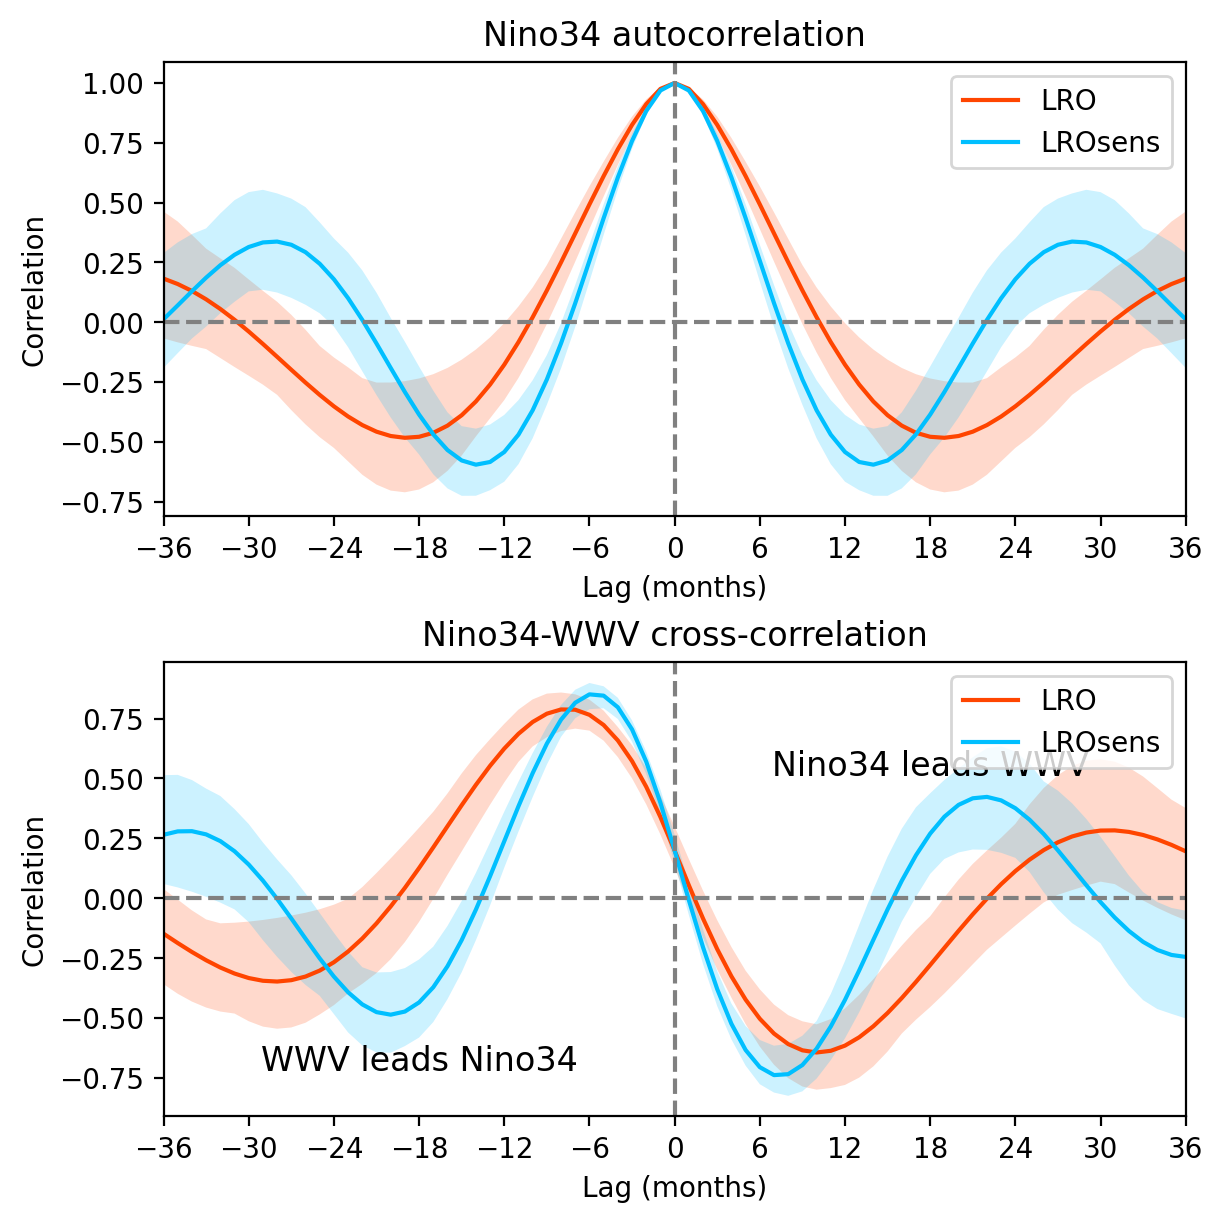

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), layout='compressed')

ax = axes[0]
sel_var = 'Nino34'
plot_fill_between(ccr_LRO_ds[sel_var], dim='member', c='orangered',
                  alpha=0.2, xtime=ccr_LRO_ds.lag, ax=ax, option=0, label='LRO')

plot_fill_between(ccr_LROsens_ds[sel_var], dim='member', c='deepskyblue',
                  alpha=0.2, xtime=ccr_LROsens_ds.lag, ax=ax, option=0, label='LROsens')
ax.set_title("Nino34 autocorrelation")

ax = axes[1]
sel_var = 'WWV'
plot_fill_between(ccr_LRO_ds[sel_var], dim='member', c='orangered',
                  alpha=0.2, xtime=ccr_LRO_ds.lag, ax=ax, option=0, label='LRO')

plot_fill_between(ccr_LROsens_ds[sel_var], dim='member', c='deepskyblue',
                  alpha=0.2, xtime=ccr_LROsens_ds.lag, ax=ax, option=0, label='LROsens')
ax.set_title("Nino34-WWV cross-correlation")

for i, ax in enumerate(axes.flat):
    ax.set_ylabel('Correlation')
    ax.set_xlabel('Lag (months)')
    ax.set_xticks(np.arange(-36, 37, step=6))
    if i==1:
        ax.text(0.25, 0.1,'WWV leads Nino34', ha='center', transform=ax.transAxes, fontsize='large')
        ax.text(0.75, 0.75,'Nino34 leads WWV', ha='center', transform=ax.transAxes, fontsize='large')
    ax.set_xlim([-36, 36])
    ax.axhline(0, ls='--', c='gray')
    ax.axvline(0, ls='--', c='gray')
    ax.legend()

## 4. RO reforecasting
### In-sample reforecast experiments
reforecasting (as an example, initial from observed 1979-01 to 2023-10, each run 21 months)
- `fit_ds` is the trained operators, in which linear/nonlinear operators `Lac`/`NLac` as well as noise parameters `xi_std` and `xi_a1` will be used
- `init_ds` is initial condictions, the order of variables has been the same with the trained parameters
- determinsitc forecast by setting `noise_type='zero'` 
- stochastic forecast by setting `noise_type='red'` and `ncopy=100` (100 members)


In [30]:
XRO_ac2.reforecast?

Signature:
XRO_ac2.reforecast(
    fit_ds,
    init_ds,
    n_month=12,
    nstep=10,
    ncopy=1,
    seed=None,
    noise_type='red',
    is_xi_stdac=True,
    xi_B=None,
    is_heaviside=False,
)
Docstring:
Generates a reforecast using the nonlinear XRO model.

Parameters:
    fit_ds (xarray.Dataset): Dataset containing model fit results.
    init_ds (xarray.Dataset): Dataset containing the initial conditions.
    n_month (int, optional): Number of months for the forecast. Default is 12.
    nstep (int, optional): Number of integration steps per cycle. Default is 10.
    ncopy (int, optional): Number of ensemble members. Default is 1.
    seed (int or None, optional): Random seed for noise generation. Default is None.
    noise_type (str, optional): Type of noise ('red' or 'white'). Default is 'red'.
    is_xi_stdac (bool, optional): If True, uses the standard deviation of the autocorrelated noise. Default is True.
    xi_B (float or np.ndarray, optional): Scaling factor for noise p

In [31]:
NRO_fcst = XRO_ac2.reforecast(fit_ds=fit_NRO, init_ds=obs_RO_ds, n_month=21, ncopy=1, noise_type='zero')
NRO_fcst

<xarray.Dataset>
Dimensions:  (lead: 22, init: 552)
Coordinates:
  * lead     (lead) int32 0 1 2 3 4 5 6 7 8 9 ... 12 13 14 15 16 17 18 19 20 21
  * init     (init) datetime64[ns] 1979-01-01 1979-02-01 ... 2024-12-01
    month    (init) int32 ...
Data variables:
    Nino34   (init, lead) float64 -0.1423 -0.1265 -0.09837 ... 0.08494 0.1399
    WWV      (init, lead) float64 11.07 11.1 11.14 11.05 ... 4.227 4.038 4.015

#### calculate forecast skill performance using `climpred`


In [32]:
def calc_forecast_skill(fcst_ds, ref_ds, metric='acc', is_mv3=True, comparison="e2o", 
                        by_month=False, verify_periods=slice('1979-01', '2022-12')):
    try:
        fcst_ds = fcst_ds.squeeze().drop('member')
    except:
        pass

    if is_mv3:
        fcst_ds = fcst_ds.rolling(init=3, center=True, min_periods=1).mean('init')
        ref_mv3 = ref_ds.rolling(time=3, center=True, min_periods=1).mean().dropna(dim='time')
    else:
        ref_mv3 = ref_ds

    hc_XRO = HindcastEnsemble(fcst_ds.sel(init=verify_periods))
    hc_XRO = hc_XRO.add_observations(ref_mv3)
    if by_month:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True, groupby='month')
    else:
        skill_XRO = hc_XRO.verify(metric=metric, comparison=comparison, alignment="maximize", dim=["init"], skipna=True)
    try:
        del skill_XRO.attrs['skipna']
        skill_XRO = skill_XRO.drop('skill')
    except:
        pass

    for var in skill_XRO.data_vars:
        if var != 'model':
            skill_XRO[var].encoding['dtype'] = 'float32'
            skill_XRO[var].encoding['_FillValue'] = 1e20
    return skill_XRO

### In-sample correlation and RMSE skills
In-sample skills of NRO for 1979-2024

In [33]:
acc_NRO = calc_forecast_skill(NRO_fcst, obs_RO_ds, metric='acc', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2024-12'))
rmse_NRO = calc_forecast_skill(NRO_fcst, obs_RO_ds, metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('1979-01', '2022-12'))

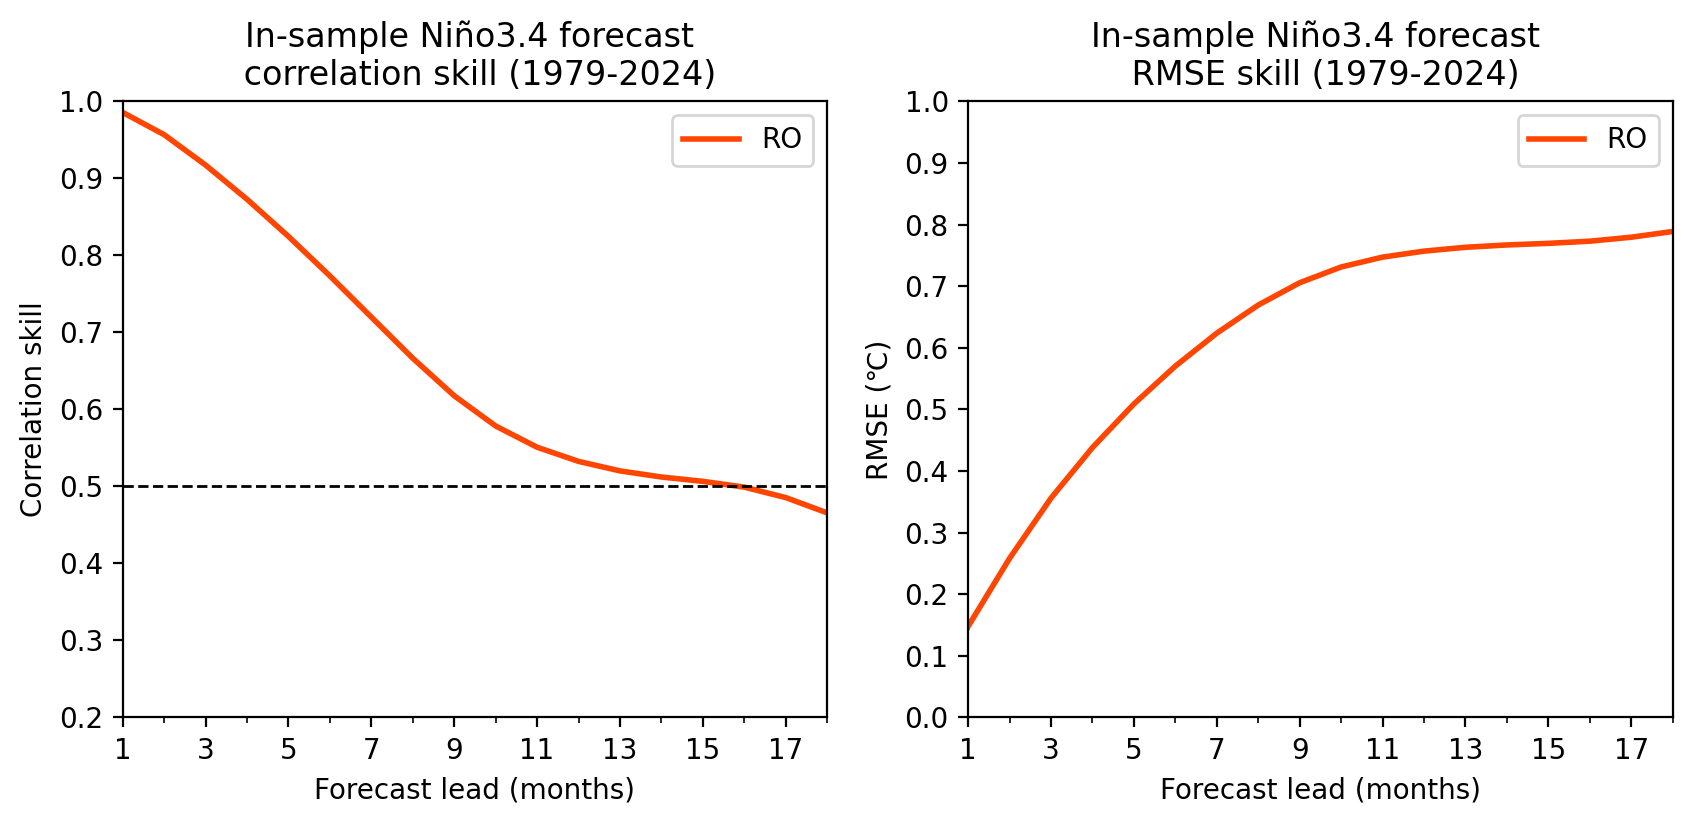

In [34]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
acc_NRO[sel_var].plot(ax=ax, label='RO', c='orangered', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0.2, 1.])
ax.set_xlim([1., 18])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('In-sample Niño3.4 forecast \n correlation skill (1979-2024)')
ax.legend()

ax = axes[1]
rmse_NRO[sel_var].plot(ax=ax, label='RO', c='orangered', lw=2)

ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 18])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('In-sample Niño3.4 forecast \n RMSE skill (1979-2024)')
ax.legend()

### Out-of-sample correlation and RMSE skills
Train model using 1979-2000
Forecast verification using 2002-2024

In [35]:
slice_train = slice('1979-01', '2000-12')
slice_verif = slice('2002-01', '2024-12')

fit_NRO_train = XRO_ac2.fit_matrix(obs_RO_ds.sel(time=slice_train), maskNT=['T2'], maskNH=['T2'])
NRO_outofsample_fcst = XRO_ac2.reforecast(fit_ds=fit_NRO_train, init_ds=obs_RO_ds.sel(time=slice_verif), n_month=21, ncopy=1, noise_type='zero')

acc_NRO_outofsample = calc_forecast_skill(NRO_outofsample_fcst, obs_RO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2002-01', '2024-12'))
rmse_NRO_outofsample = calc_forecast_skill(NRO_outofsample_fcst, obs_RO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2002-01', '2022-12'))

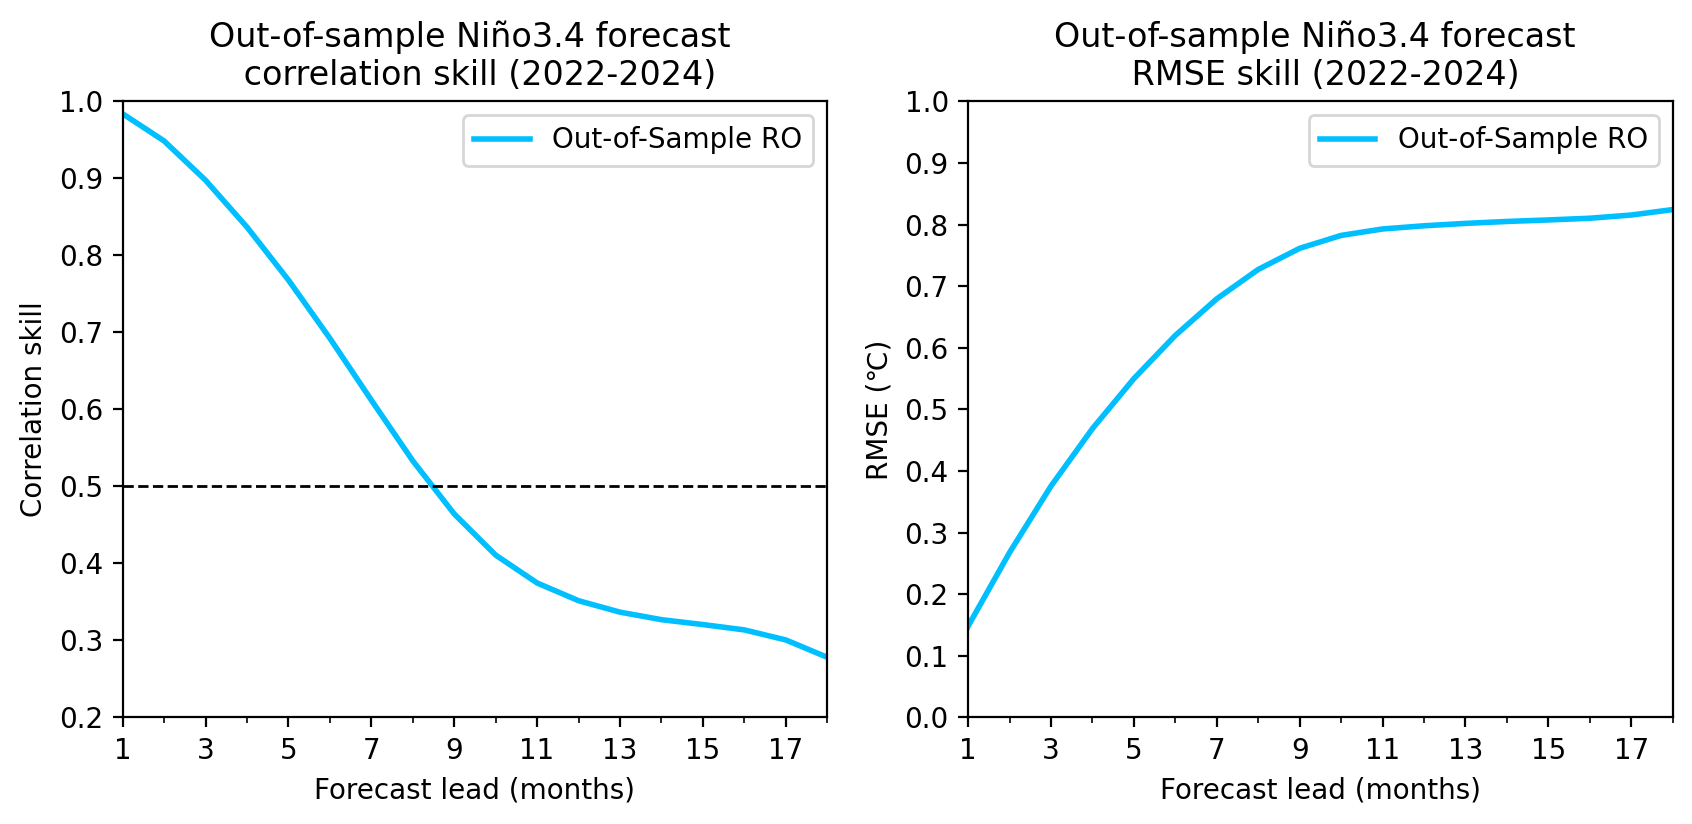

In [36]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
acc_NRO_outofsample[sel_var].plot(ax=ax, label='Out-of-Sample RO', c='deepskyblue', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0.2, 1.])
ax.set_xlim([1., 18])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('Out-of-sample Niño3.4 forecast \n correlation skill (2022-2024)')
ax.legend()

ax = axes[1]
rmse_NRO_outofsample[sel_var].plot(ax=ax, label='Out-of-Sample RO', c='deepskyblue', lw=2)

ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 18])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('Out-of-sample Niño3.4 forecast \n RMSE skill (2022-2024)')
ax.legend()

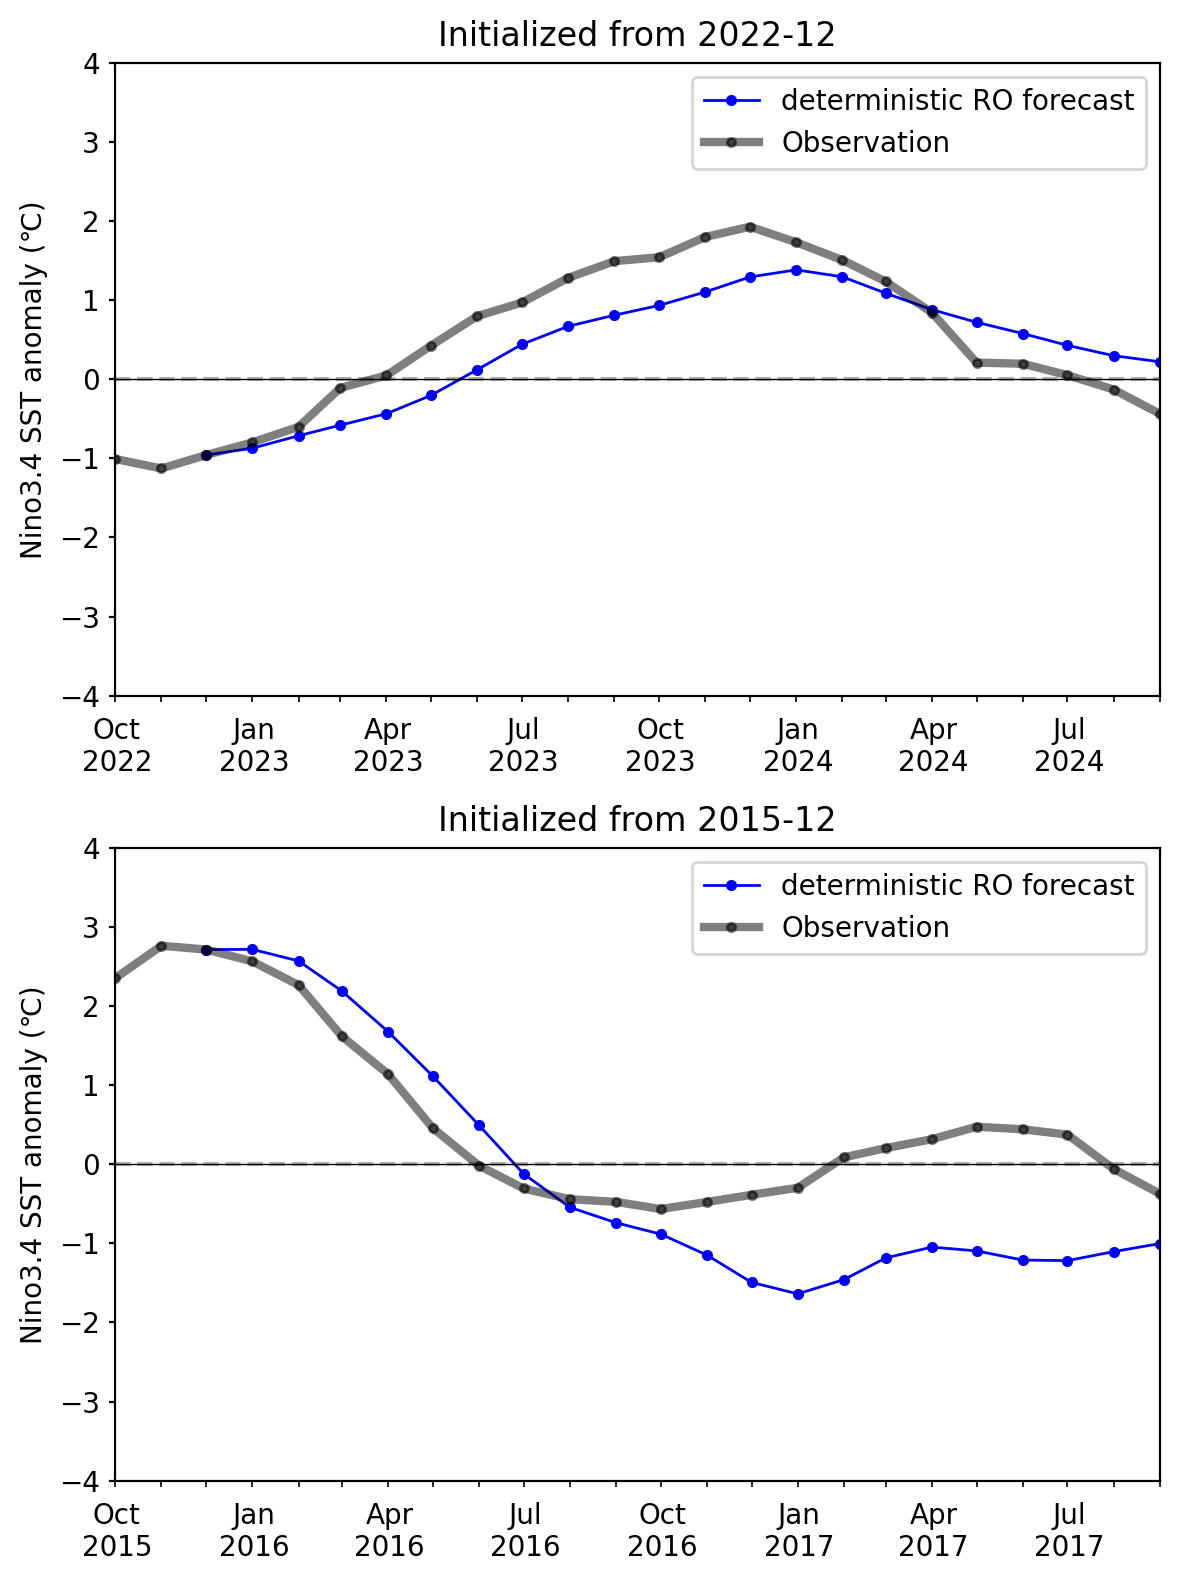

In [37]:
date_arrs = ['2022-12', '2015-12']

n_arr = len(date_arrs)
fig, axes = plt.subplots(n_arr, 1, figsize=(6, 4*n_arr), sharex=False, sharey=False,) # layout='compressed'

for i, sel_date in enumerate(date_arrs):
    ax = axes.flat[i]

    sel_fcst_d = NRO_outofsample_fcst['Nino34'].sel(init=sel_date).squeeze()
    # sel_fcst_m = ROac2_fcst_stoc['Nino34'].sel(init=sel_date).mean('member').squeeze()
    # sel_fcst_e = ROac2_fcst_stoc['Nino34'].sel(init=sel_date).std('member').squeeze()
    nlead = len(sel_fcst_d.lead)
    
    xdate_mid = datetime.datetime.strptime(sel_date+'-01', "%Y-%m-%d").date()
    xdate_strt = datetime.datetime.strptime(sel_date+'-01', "%Y-%m-%d").date() + relativedelta(months=-2)
    xdate_last = datetime.datetime.strptime(sel_date+'-01', "%Y-%m-%d").date() + relativedelta(months=nlead-1)
    
    sel_obs = obs_ds['Nino34'].sel(time=slice(xdate_strt, xdate_last))
    xtime = sel_obs.time
    xtime_fcst = xtime[2:]
    
    # ax.plot(xtime_fcst, sel_fcst_m, c='orangered', marker='.', lw=3, label='100-members RO stochastic forecasts')

    # ax.fill_between(xtime_fcst,sel_fcst_m-sel_fcst_e, sel_fcst_m + sel_fcst_e, fc='red', alpha=0.3, ) #label='100-members stochastic forecasts'
    ax.plot(xtime_fcst, sel_fcst_d, c='blue', marker='.', lw=1, label='deterministic RO forecast' )
    ax.plot(xtime, sel_obs, c='black', marker='.', lw=3, label='Observation', alpha=0.5 )

    ax.axhline(y=0., c = 'black', ls='-', lw=0.5)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator((1, 4, 7, 10), bymonthday=2))
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator( interval=1, bymonthday=1))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b\n%Y"))
    # ax.set_xticklabels(xdate_minorticks , minor=True,) 

    ax.tick_params(axis="x", which="minor", length=2)
    ax.tick_params(axis="y", which="major", length=2)
    ax.tick_params(axis="x", which="major", length=4, color=(0., 0., 0., 0))
    plt.setp(ax.get_xticklabels(minor=False), rotation=0, ha="center")
    plt.setp(ax.get_xticklabels(minor=True), rotation=0, ha="center")
    ax.set_xlim([xdate_strt, xdate_last])
    
    ax.set_title("Initialized from {0}".format(sel_date))
    # ax.set_xlim([1980, 2025])
    ax.set_ylim([-4., 4.])
    ax.set_ylabel('Nino3.4 SST anomaly (℃)')
    ax.axhline(0, c='k', ls='--', alpha=0.3)
    ax.legend()
fig.tight_layout()

## 5. RO model extensions (Extended nonlinear Recharge Oscillator, XRO)
[<img src="https://raw.githubusercontent.com/senclimate/XRO/af41cdef674028c948f7f2f8f21b4ef4d10141f0/XRO_logo.png" width="500">](https://github.com/senclimate/XRO)


$X_M = [T_{NPMM},T_{SPMM},T_{IOB},T_{IOD},T_{SIOD},T_{TNA},T_{ATL3},T_{SASD}]$, respectively.

See the defitions of those SST and WWV indices from Zhao et al. (2024). For briefty, here we use the observed indices from ORAS5 reanalysis for 1979-2024 as an exmaple.\

 - stochastic forecast by setting `noise_type='red'` and `ncopy=100` (100 members)

It will take a while since you have 100 members, of course you can reduce the member size

and 

In [38]:
obs_XRO_ds = obs_ds[['Nino34', 'WWV', 'NPMM', 'SPMM', 'IOB', 'IOD', 'SIOD', 'TNA', 'ATL3', 'SASD']]
obs_XRO_ds

<xarray.Dataset>
Dimensions:  (time: 552)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2024-12-01
    month    (time) int32 ...
Data variables:
    Nino34   (time) float32 -0.1423 0.02629 -0.08266 ... -0.5462 -0.3615 -0.7938
    WWV      (time) float32 11.07 10.96 5.943 2.832 ... -10.61 -8.805 -9.877
    NPMM     (time) float32 ...
    SPMM     (time) float32 ...
    IOB      (time) float32 ...
    IOD      (time) float32 ...
    SIOD     (time) float32 ...
    TNA      (time) float32 ...
    ATL3     (time) float32 ...
    SASD     (time) float32 ...

Fitting on the observation

In [39]:
slice_train = slice('1979-01', '2000-12')
slice_verif = slice('2002-01', '2024-12')

fit_XRO_train = XRO_ac2.fit_matrix(obs_XRO_ds.sel(time=slice_train), maskNT=['T2', 'TH'], maskNH=['T2'], maskb=['IOD'])

XRO_outofsample_fcst = XRO_ac2.reforecast(fit_ds=fit_XRO_train, init_ds=obs_XRO_ds.sel(time=slice_verif), n_month=21, ncopy=1, noise_type='zero')


In [40]:
acc_XRO_outofsample = calc_forecast_skill(XRO_outofsample_fcst, obs_RO_ds.sel(time=slice_verif), 
                                          metric='acc', is_mv3=True, by_month=False, verify_periods=slice('2002-01', '2024-12'))

rmse_XRO_outofsample = calc_forecast_skill(XRO_outofsample_fcst, obs_RO_ds.sel(time=slice_verif), 
                                           metric='rmse', is_mv3=True, by_month=False, verify_periods=slice('2002-01', '2022-12'))

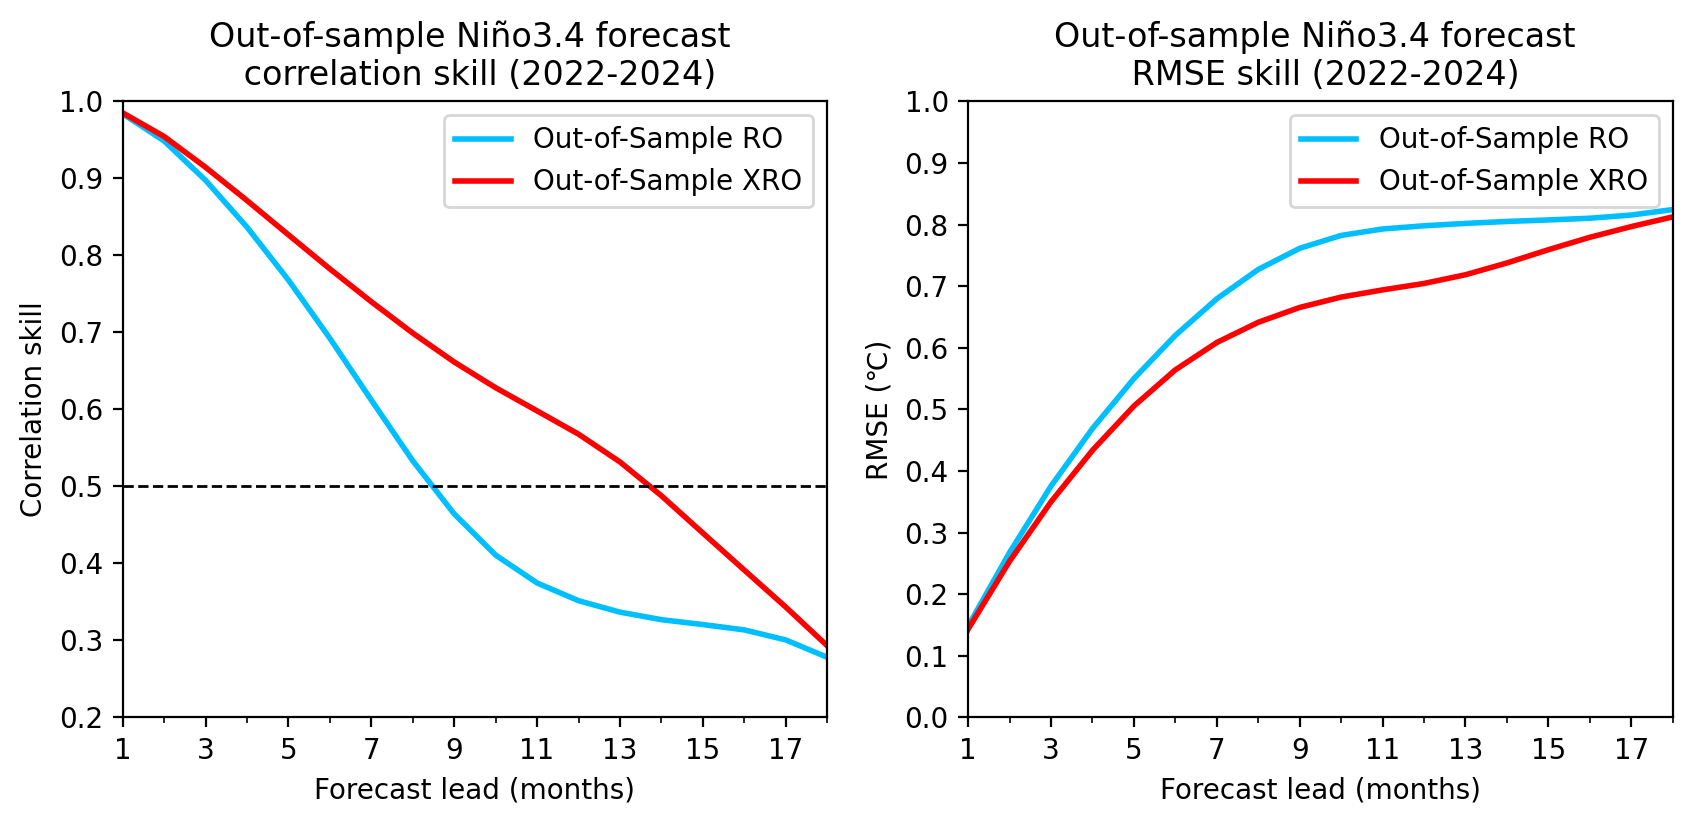

In [41]:
sel_var = 'Nino34'
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
acc_NRO_outofsample[sel_var].plot(ax=ax, label='Out-of-Sample RO', c='deepskyblue', lw=2)
acc_XRO_outofsample[sel_var].plot(ax=ax, label='Out-of-Sample XRO', c='red', lw=2)
ax.set_ylabel('{0} skill'.format('Correlation') )
ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0.2, 1.])
ax.set_xlim([1., 18])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.axhline(0.5, ls='--', c='black', lw=1.)
ax.set_title('Out-of-sample Niño3.4 forecast \n correlation skill (2022-2024)')
ax.legend()

ax = axes[1]
rmse_NRO_outofsample[sel_var].plot(ax=ax, label='Out-of-Sample RO', c='deepskyblue', lw=2)
rmse_XRO_outofsample[sel_var].plot(ax=ax, label='Out-of-Sample XRO', c='red', lw=2)

ax.set_ylabel('{0} (℃)'.format('RMSE') )

ax.set_yticks(np.arange(0, 2.01, step=0.1))
ax.set_xticks(np.arange(1, 24, step=2))
ax.set_ylim([0., 1.])
ax.set_xlim([1., 18])
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Forecast lead (months)')
ax.set_title('Out-of-sample Niño3.4 forecast \n RMSE skill (2022-2024)')
ax.legend()